In [1]:
! python --version

Python 3.11.9


In [86]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.lines import Line2D
from matplotlib.collections import PatchCollection
from matplotlib import patches

import seaborn as sns

import scipy.sparse

import geopandas as gpd

import scanpy as sc

import anndata as an
import scanorama

from pathlib import Path

import squidpy as sq

import os
import warnings

from shapely.geometry import Polygon, MultiPolygon, Point
from shapely.affinity import affine_transform

import math

sc.logging.print_versions()

-----
anndata     0.10.7
scanpy      1.10.0
-----
PIL                         10.3.0
annoy                       NA
anyio                       NA
asciitree                   NA
asttokens                   NA
attr                        23.1.0
attrs                       23.1.0
babel                       2.11.0
brotli                      1.0.9
certifi                     2024.02.02
cffi                        1.16.0
charset_normalizer          2.0.4
cloudpickle                 3.0.0
colorama                    0.4.6
comm                        0.2.1
cycler                      0.12.1
cython_runtime              NA
dask                        2024.5.0
dask_expr                   1.1.0
dask_image                  2023.08.1
datashader                  0.16.1
datatree                    0.0.14
dateutil                    2.8.2
debugpy                     1.6.7
decorator                   5.1.1
defusedxml                  0.7.1
docrep                      0.3.2
executing                  

In [2]:
warnings.simplefilter("ignore")

In [4]:
custom_palette = [ "#a70e62", "#e10e3c", "#f47140", "#f0b932", "#ffd95a", "#c2ed51", "#8ed73d", "#489c73", "#1a8d83", 
                  "#4915be", "#2357d5", "#fed2ff", "#6ecad5", "#BD08F9", '#886fc2', "#e170c0", "#FF33CC", "#e4a9e8"]

# Read the list of genes, 200 spike genes subset 
genes_to_include_file =  "subset_spikegenes_list.txt"

with open(genes_to_include_file, "r") as file:
    genes_to_include = [line.strip() for line in file]


VGN1e1 = late double ridge, VRT-A2a (P1 WT) <p>
VGN1e9 = late double ridge, VRT-A2b (P1 Pol) <p>
VGN1b6 = lemma primorida, VRT-A2a (P1 WT) <p>
VGN1b8 = lemma primorida, VRT-A2b (P1 Pol) <p>
VGN1a6 = terminal spikelet, VRT-A2a (P1 WT) <p>
VGN1a4 = terminal spikelet, VRT-A2b (P1 Pol) <p>
VGN1c2 = carpel extension round, VRT-A2a (P1 WT) <p>
VGN1c3 = carpel extension round, VRT-A2b (P1 Pol)


### First I am going to read in my filtered & normalised adata objects for each sample

In [5]:
# Define the filenames of the saved AnnData objects
adata_filenames = {
    "adata_VGN1a6": "qc/adata_VGN1a6_clean.h5ad",
    "adata_VGN1a4": "qc/adata_VGN1a4_clean.h5ad",
    "adata_VGN1b6": "qc/adata_VGN1b6_clean.h5ad",
    "adata_VGN1b8": "qc/adata_VGN1b8_clean.h5ad",
    "adata_VGN1e1": "qc/adata_VGN1e1_clean.h5ad",
    "adata_VGN1e9": "qc/adata_VGN1e9_clean.h5ad",
    "adata_VGN1c2": "qc/adata_VGN1c2_clean.h5ad",
    "adata_VGN1c3": "qc/adata_VGN1c3_clean.h5ad"
}

# Initialize a dictionary to store the loaded AnnData objects
loaded_adata_objects = {}

# Load each file and store it in the dictionary
for name, filename in adata_filenames.items():
    loaded_adata_objects[name] = sc.read_h5ad(filename)
    print(f"Loaded {name} from {filename}")

# Access the loaded AnnData objects
adata_VGN1a6 = loaded_adata_objects["adata_VGN1a6"]
adata_VGN1a4 = loaded_adata_objects["adata_VGN1a4"]

adata_VGN1b6 = loaded_adata_objects["adata_VGN1b6"]
adata_VGN1b8 = loaded_adata_objects["adata_VGN1b8"]


adata_VGN1e1 = loaded_adata_objects["adata_VGN1e1"]
adata_VGN1e9 = loaded_adata_objects["adata_VGN1e9"]


adata_VGN1c2 = loaded_adata_objects["adata_VGN1c2"]
adata_VGN1c3 = loaded_adata_objects["adata_VGN1c3"]

Loaded adata_VGN1a6 from qc/adata_VGN1a6_clean.h5ad
Loaded adata_VGN1a4 from qc/adata_VGN1a4_clean.h5ad
Loaded adata_VGN1b6 from qc/adata_VGN1b6_clean.h5ad
Loaded adata_VGN1b8 from qc/adata_VGN1b8_clean.h5ad
Loaded adata_VGN1e1 from qc/adata_VGN1e1_clean.h5ad
Loaded adata_VGN1e9 from qc/adata_VGN1e9_clean.h5ad
Loaded adata_VGN1c2 from qc/adata_VGN1c2_clean.h5ad
Loaded adata_VGN1c3 from qc/adata_VGN1c3_clean.h5ad


### Now I will look at clustering my data by integrating all the samples together with scanorama and performing leiden clustering

I am following this documentation: 
https://scanpy-tutorials.readthedocs.io/en/latest/spatial/integration-scanorama.html#Data-integration

In [7]:
adata_VGN1a6.obs['dataset'] = 'VGN1a6'
adata_VGN1a4.obs['dataset'] = 'VGN1a4'
adata_VGN1b6.obs['dataset'] = 'VGN1b6'
adata_VGN1b8.obs['dataset'] = 'VGN1b8'
adata_VGN1c2.obs['dataset'] = 'VGN1c2'
adata_VGN1c3.obs['dataset'] = 'VGN1c3'
adata_VGN1e1.obs['dataset'] = 'VGN1e1'
adata_VGN1e9.obs['dataset'] = 'VGN1e9'

adatas = [adata_VGN1a6, adata_VGN1a4, adata_VGN1b6, adata_VGN1b8, adata_VGN1c2, adata_VGN1c3, adata_VGN1e1, adata_VGN1e9]
keys = ['VGN1a6', 'VGN1a4', 'VGN1b6', 'VGN1b8', 'VGN1c2', 'VGN1c3', 'VGN1e1', 'VGN1e9'] 
# Add unique labels for concatenation

#create new AnnData objects and replace adata.X with the Scanorama-transformed cell-by-gene matrix, while keeping the other metadata in adata as well.
#The adata.X (expression score) will be corrected and scaled so that we can look between different samples and concatenate them into one. 
adatas_cor = scanorama.correct_scanpy(adatas, return_dimred=True)

# Concatenate corrected datasets
adata_spatial = sc.concat(
    adatas_cor,
    label="dataset",  # Use the 'dataset' column as label
    uns_merge="unique",
    keys=keys,
    index_unique="-",
)
# perform UMAP clustering of the concatenated samples
sc.pp.neighbors(adata_spatial, use_rep="X_scanorama")
sc.tl.umap(adata_spatial)

sc.tl.leiden(adata_spatial, resolution = 1, key_added="clusters", directed=False)

Found 200 genes among all datasets
[[0.         0.74560592 0.62879834 0.53725676 0.55078631 0.41609621
  0.36939792 0.36073932]
 [0.         0.         0.59564917 0.51637399 0.6898982  0.57102584
  0.19963785 0.18546845]
 [0.         0.         0.         0.65685809 0.4371547  0.2406768
  0.45359891 0.30592734]
 [0.         0.         0.         0.         0.4717608  0.37399146
  0.34314169 0.3486297 ]
 [0.         0.         0.         0.         0.         0.83118531
  0.33001358 0.27597196]
 [0.         0.         0.         0.         0.         0.
  0.51923947 0.46462715]
 [0.         0.         0.         0.         0.         0.
  0.         0.84384959]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]]
Processing datasets (6, 7)
Processing datasets (4, 5)
Processing datasets (0, 1)
Processing datasets (1, 4)
Processing datasets (2, 3)
Processing datasets (0, 2)
Processing datasets (1, 2)
Processing datasets (1, 5)
Processing datasets (0, 4)
Pr

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


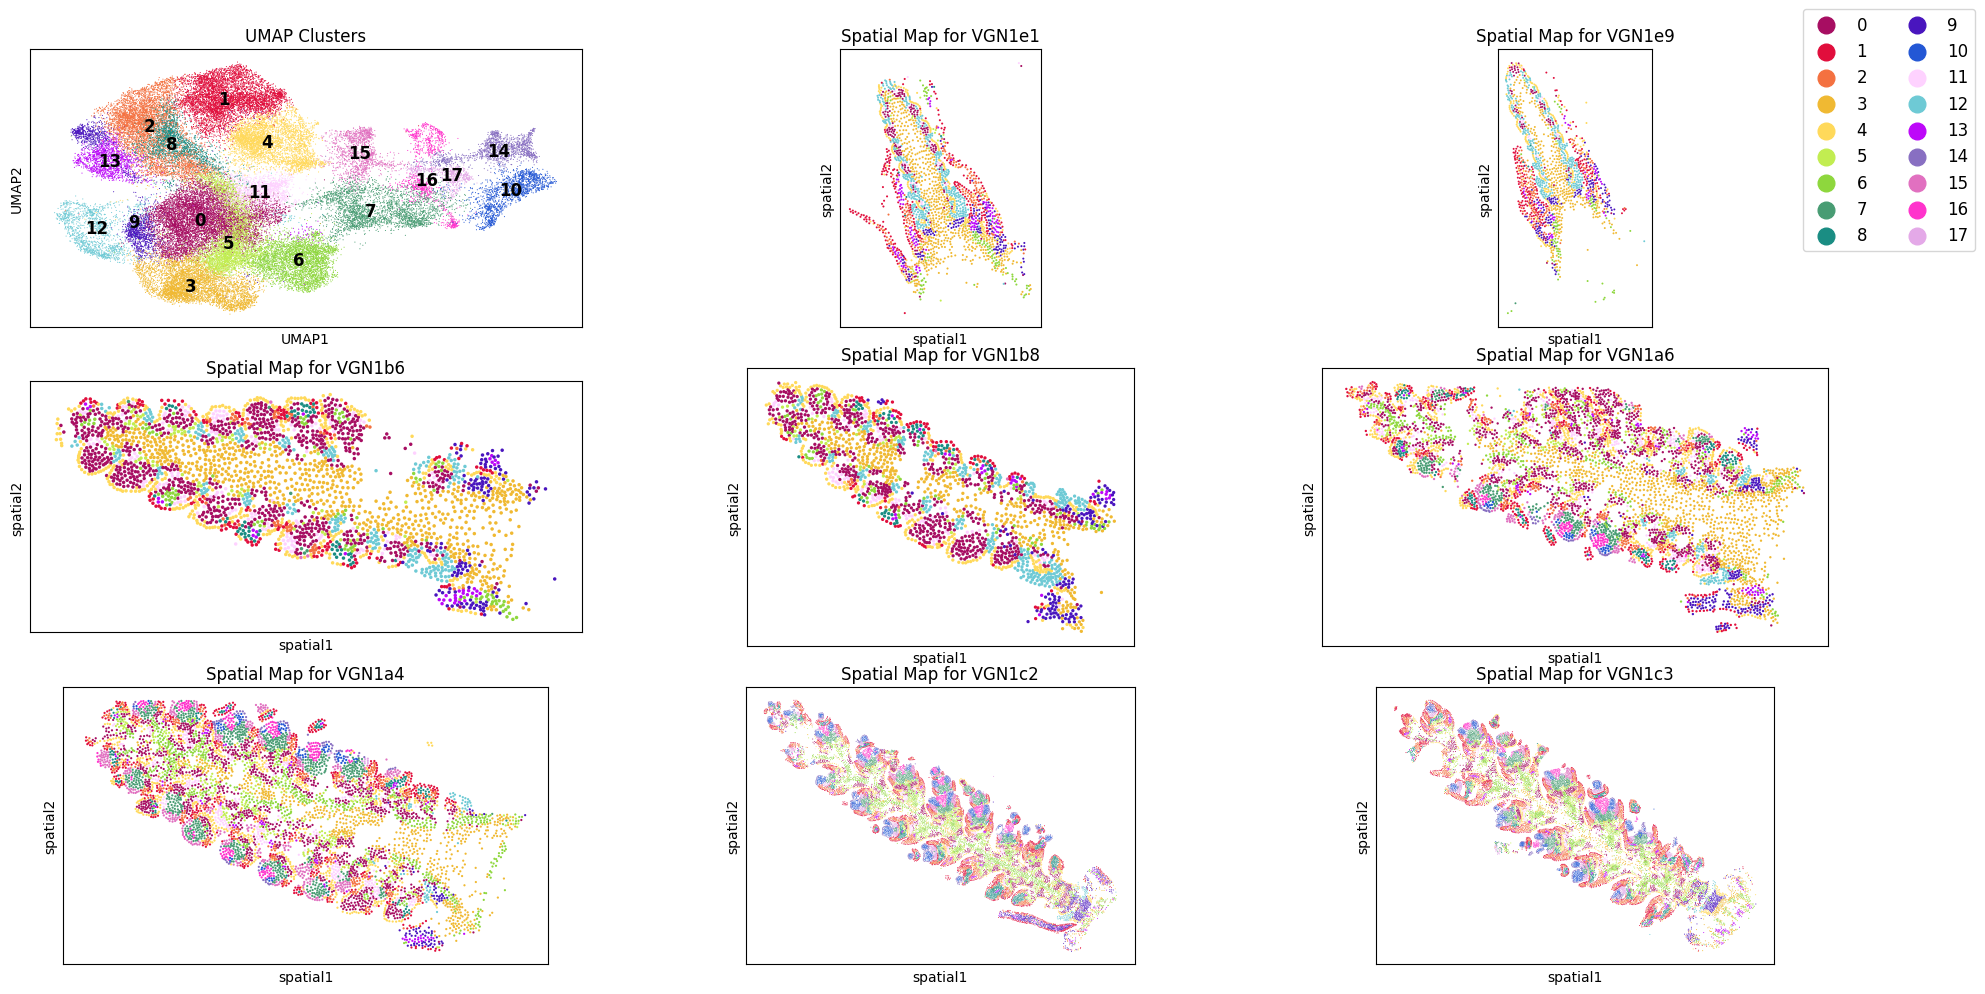

In [14]:
# Visualising the clusters we made by making the UMAP and spatial plots before plotting out individually 

# Define the keys in the required order
keys = ['VGN1e1', 'VGN1e9', 'VGN1b6', 'VGN1b8', 'VGN1a6', 'VGN1a4', 'VGN1c2', 'VGN1c3']

# Set plot background to black
plt.style.use('default')

# Create a figure with subplots
fig, axes = plt.subplots(3, 3, figsize=(20, 10))  # 2 rows, 3 columns

# Plot UMAP for "clusters"
sc.pl.umap(
    adata_spatial, color="clusters", palette=custom_palette, ax=axes[0, 0], show=False, legend_loc="on data", legend_fontsize=12)

axes[0, 0].set_title("UMAP Clusters")

# Define a dictionary to keep track of colors already added to the legend
legend_colors = {}

# Plot spatial plots for each sample
for i, sample in enumerate(keys):
    row, col = divmod(i + 1, 3)  # Adjust index to ensure all spatial plots are displayed
    ax = axes[row, col]
    if sample in ["VGN1a6", "VGN1b6", "VGN1e1", "VGN1e9", "VGN1b8", "VGN1a4"]:
        adata_sample = adata_spatial[adata_spatial.obs['dataset'] == sample].copy()
        # Swap x and y coordinates
        adata_sample.obsm["spatial"][:, [0, 1]] = adata_sample.obsm["spatial"][:, [1, 0]]
        if sample == "VGN1a6":
            # Rotate 90 degrees counterclockwise
            adata_sample.obsm["spatial"][:, 0] = adata_sample.obsm["spatial"][:, 0] * -1
        elif sample == "VGN1b6":
            # Rotate 90 degrees clockwise
            adata_sample.obsm["spatial"][:, 1] = adata_sample.obsm["spatial"][:, 1] * -1
        elif sample == "VGN1b8":
            # Rotate 90 degrees
            adata_sample.obsm["spatial"][:, 1] = adata_sample.obsm["spatial"][:, 1] * -1
        elif sample == "VGN1a4":
            # Rotate 90 degrees
            adata_sample.obsm["spatial"][:, 0] = adata_sample.obsm["spatial"][:, 0] * -1
        elif sample == "VGN1e1":
            adata_sample = adata_spatial[adata_spatial.obs['dataset'] == sample].copy()
            # Rotate 180 degrees separately for each axis
            adata_sample.obsm["spatial"][:, 0] *= -1
            adata_sample.obsm["spatial"][:, 1] *= -1
        elif sample == "VGN1e9":
            adata_sample = adata_spatial[adata_spatial.obs['dataset'] == sample].copy()
            # Rotate 180 degrees separately for each axis
            adata_sample.obsm["spatial"][:, 0] *= -1
            adata_sample.obsm["spatial"][:, 1] *= -1
        sc.pl.spatial(
            adata_sample,  # Filter data for the current sample
            color="clusters",
            spot_size=12,  # Provide a spot size value here
            title=f"Spatial Map for {sample}",  # Set a title for each plot
            ax=ax, show=False,
        )
    else:
        sc.pl.spatial(
            adata_spatial[adata_spatial.obs['dataset'] == sample],  # Filter data for the current sample
            color="clusters",
            spot_size=12,  # Provide a spot size value here
            title=f"Spatial Map for {sample}",  # Set a title for each plot
            ax=ax, show=False,
        )

# Adjust layout
plt.tight_layout()

# Remove legends from subplots
for ax in axes.flat:
    ax.legend().remove()

plt.subplots_adjust(hspace=0.15, wspace=0.15)


# Create a single legend for the entire figure without color indicators
handles, labels = fig.axes[7].get_legend_handles_labels()  # Get legend handles and labels from any subplot
# Print only the first 23 labels
fig.legend(handles[:18], labels[:18], loc='upper right', bbox_to_anchor=(0.99, 0.99), borderaxespad=0., ncol=2, fontsize='large', markerscale=2)

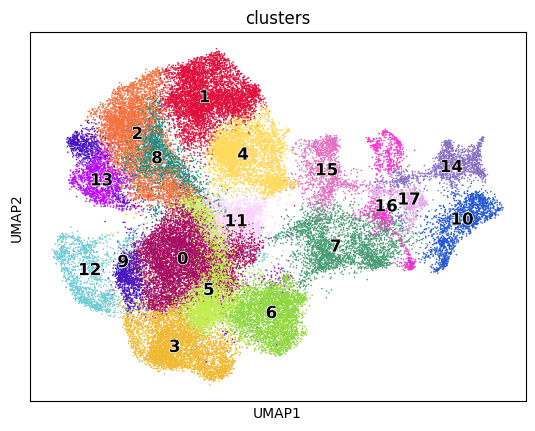

In [7]:
sc.pl.umap(
    adata_spatial, color="clusters", palette=custom_palette, show=False, legend_loc="on data", legend_fontsize=12, legend_fontoutline= 1 , size=5)

plt.savefig("leidenclustering/UMAP_VRT_A2a_A2b_200genes_res1_white.svg", dpi=300, bbox_inches='tight', format='svg', transparent=True)

### Saving cluster information into hdf5 file 

In [15]:
#this file contains the same information in the index, I will use this for analysis 
file_path = "leidenclustering/VRT_A2a_A2b_leiden_200genes_res1_indexed.h5ad"
adata_spatial.write_h5ad(file_path)

#When I am importing .hdf5 files to the VizGen visualiser I need to remove all of the sample information included in the index
# Rename the index column to only include the numbers before the '-' character
adata_indexing = adata_spatial.copy()
adata_indexing.obs.index = [index.split('-')[0] for index in adata_indexing.obs.index]

# Assuming your AnnData object is named 'adata'
file_path = "leidenclustering/VRT_A2a_A2b_leiden_200genes_res1.hdf5"
# Save the AnnData object as an HDF5 file
adata_indexing.write_h5ad(file_path)


## Creating a table with each cell and their domain assignment 
</p>
Supplemental Table 9:
Cell ID, domain assignment, sample id

In [8]:
cluster_info = adata_spatial.obs['clusters'].copy()
cluster_assignment_df = cluster_info.reset_index()
cluster_assignment_df[['cell_id', 'sample']] = cluster_assignment_df['index'].str.split('-', expand=True)
cluster_assignment_df.drop(columns=['index'], inplace=True)
cluster_assignment_df.to_csv("leidenclustering/DomainAssignment_PerCell.csv", index=False)
cluster_assignment_df

clusters              cell_id  sample
0            0  2305551000002100247  VGN1a6
1            3  2305551000002100249  VGN1a6
2            9  2305551000002100250  VGN1a6
3            3  2305551000002100262  VGN1a6
4            6  2305551000002100268  VGN1a6
...        ...                  ...     ...
50726        4  2655507000138100169  VGN1e9
50727        4  2655507000138100170  VGN1e9
50728        0  2655507000138100176  VGN1e9
50729        4  2655507000138100177  VGN1e9
50730        0  2655507000138100178  VGN1e9

[50731 rows x 3 columns]

### Calculating total cells per cluster and percentage of total cells per cluster

In [9]:
cluster_info = adata_spatial.obs['clusters'].copy()
df = cluster_info.reset_index()
df[['cell_id', 'sample']] = df['index'].str.split('-', expand=True)
df.drop(columns=['index'], inplace=True)
cluster_sample_counts = df.groupby(['clusters', 'sample']).size().reset_index(name='cell_count')

sample_order = ['VGN1e1', 'VGN1b6', 'VGN1a6', 'VGN1c2']

# Filter the DataFrame to include only the specified samples
cluster_sample_counts_filtered = cluster_sample_counts[cluster_sample_counts['sample'].isin(sample_order)]

# Set the 'sample' column as a categorical type with the specified order
cluster_sample_counts_filtered['sample'] = pd.Categorical(cluster_sample_counts_filtered['sample'], categories=sample_order, ordered=True)

# Sort the DataFrame by the 'sample' column based on the categorical order
cluster_sample_counts_ordered = cluster_sample_counts_filtered.sort_values('sample')

# Calculate the total number of cells per sample
total_cells_per_sample = cluster_sample_counts_ordered.groupby('sample')['cell_count'].sum().reset_index(name='total_cells')

# Merge the total cells with the original filtered DataFrame
cluster_sample_counts_w_total = pd.merge(cluster_sample_counts_ordered, total_cells_per_sample, on='sample')

# Calculate the percentage of cells per cluster in each sample
cluster_sample_counts_w_total['percentage'] = (cluster_sample_counts_w_total['cell_count'] / cluster_sample_counts_w_total['total_cells']) * 100


cluster_sample_counts_w_total.to_csv("leidenclustering/percentages_Fig2f.csv", index=False)
cluster_sample_counts_w_total

clusters  sample  cell_count  total_cells  percentage
0         8  VGN1e1           6         2209    0.271616
1        16  VGN1e1           0         2209    0.000000
2        15  VGN1e1           1         2209    0.045269
3        14  VGN1e1           0         2209    0.000000
4        13  VGN1e1         116         2209    5.251245
..      ...     ...         ...          ...         ...
67       10  VGN1c2         871        15185    5.735924
68        3  VGN1c2         349        15185    2.298321
69       13  VGN1c2         399        15185    2.627593
70        9  VGN1c2         598        15185    3.938097
71       11  VGN1c2         362        15185    2.383932

[72 rows x 5 columns]

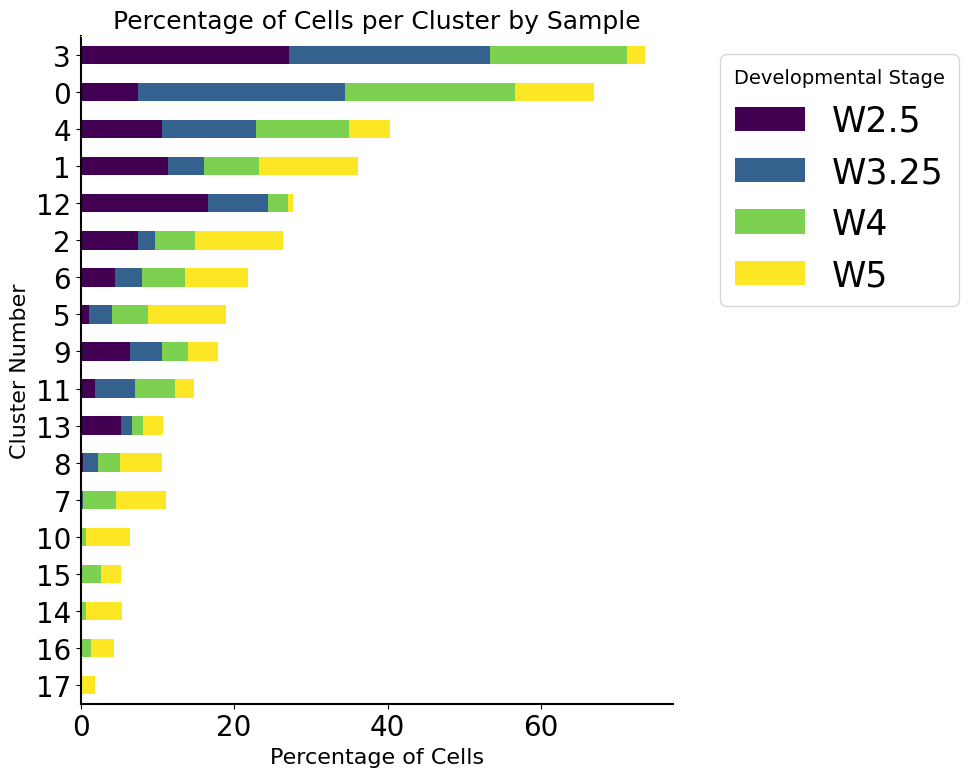

In [10]:
plt.style.use('default')

# Define the custom cluster order
cluster_order = ['17', '16', '14', '15', '10', '7', '8', '13', '11', '9', '5', '6', '2', '12', '1', '4', '0', '3']

# Pivot the DataFrame so that clusters are the index, samples are the columns, and percentage of cells are the values
pivot_df_percentage = cluster_sample_counts_w_total.pivot_table(index='clusters', columns='sample', values='percentage', fill_value=0)

# Reorder the columns according to the custom cluster order
pivot_df_percentage = pivot_df_percentage.reindex(cluster_order)

# Sample-to-stage mapping
sample_to_stage = {
    'VGN1e1': 'W2.5',
    'VGN1b6': 'W3.25',
    'VGN1a6': 'W4',
    'VGN1c2': 'W5'
}

# Map the columns (sample IDs) to their corresponding stages
pivot_df_percentage.rename(columns=sample_to_stage, inplace=True)

# Set font sizes for the entire plot
plt.rc('font', size=14)          # Global font size
plt.rc('axes', titlesize=20)     # Title font size
plt.rc('axes', labelsize=20)     # Axis labels font size
plt.rc('xtick', labelsize=20)    # X-axis tick labels font size
plt.rc('ytick', labelsize=20)    # Y-axis tick labels font size
plt.rc('legend', fontsize=25)    # Legend font size

# Create the bar plot
ax = pivot_df_percentage.plot(kind='barh', stacked=True, figsize=(10, 8), color=['#410052', '#34618D', '#7CD250', '#FDE725'], edgecolor='none')

# Set labels and title
ax.set_xlabel('Percentage of Cells', fontsize=16)
ax.set_ylabel('Cluster Number', fontsize=16)
ax.set_title('Percentage of Cells per Cluster by Sample', fontsize=18)

# Customize the spines (borders)
ax.spines['top'].set_color('white')   # Set top border to white (invisible)
ax.spines['right'].set_color('white') # Set right border to white (invisible)
ax.spines['bottom'].set_color('black') # Set x-axis spine (bottom) to black
ax.spines['left'].set_color('black')   # Set y-axis spine (left) to black
ax.spines['bottom'].set_linewidth(1.5) # Optionally, increase the thickness of x-axis
ax.spines['left'].set_linewidth(1.5)   # Optionally, increase the thickness of y-axis

# Add legend outside the plot
plt.legend(title='Developmental Stage', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig("leidenclustering/Percentage_Cells_PerCluster_bystage.svg", dpi=300, bbox_inches='tight', format='svg', transparent=True)
plt.show()


# Gene enrichment analysis 

Logistic Regression
Description: This method models the probability of a gene being expressed in one cluster versus others
A higher score means that the gene is more likely to be associated with the cluster in question. Conversely, lower or negative scores suggest that the gene is less expressed in that cluster relative to others.

See publication: A discriminative learning approach to differential expression analysis for single-cell RNA-seq

In [10]:
sc.tl.rank_genes_groups(adata_spatial, groupby='clusters', method='logreg')

In [11]:
# Inspect the keys in the rank_genes_groups result
result = adata_spatial.uns['rank_genes_groups']
print(result.keys())

dict_keys(['params', 'names', 'scores'])


### i want these values exported as a dataframe containing Gene, LogReg Score, and normalised counts (by sample) 

(Supplementary Table 10)

In [12]:
#loading my adata objects again 
adata_filenames = {
    "adata_VGN1a6": "qc/adata_VGN1a6_clean.h5ad",
    "adata_VGN1a4": "qc/adata_VGN1a4_clean.h5ad",
    "adata_VGN1b6": "qc/adata_VGN1b6_clean.h5ad",
    "adata_VGN1b8": "qc/adata_VGN1b8_clean.h5ad",
    "adata_VGN1e1": "qc/adata_VGN1e1_clean.h5ad",
    "adata_VGN1e9": "qc/adata_VGN1e9_clean.h5ad",
    "adata_VGN1c2": "qc/adata_VGN1c2_clean.h5ad",
    "adata_VGN1c3": "qc/adata_VGN1c3_clean.h5ad"
}

# Initialize a dictionary to store the loaded AnnData objects
loaded_adata_objects = {}

# Load each file and store it in the dictionary
for name, filename in adata_filenames.items():
    loaded_adata_objects[name] = sc.read_h5ad(filename)
    print(f"Loaded {name} from {filename}")

# Access the loaded AnnData objects
adata_VGN1a6 = loaded_adata_objects["adata_VGN1a6"]
adata_VGN1a4 = loaded_adata_objects["adata_VGN1a4"]

adata_VGN1b6 = loaded_adata_objects["adata_VGN1b6"]
adata_VGN1b8 = loaded_adata_objects["adata_VGN1b8"]


adata_VGN1e1 = loaded_adata_objects["adata_VGN1e1"]
adata_VGN1e9 = loaded_adata_objects["adata_VGN1e9"]


adata_VGN1c2 = loaded_adata_objects["adata_VGN1c2"]
adata_VGN1c3 = loaded_adata_objects["adata_VGN1c3"]

Loaded adata_VGN1a6 from qc/adata_VGN1a6_clean.h5ad
Loaded adata_VGN1a4 from qc/adata_VGN1a4_clean.h5ad
Loaded adata_VGN1b6 from qc/adata_VGN1b6_clean.h5ad
Loaded adata_VGN1b8 from qc/adata_VGN1b8_clean.h5ad
Loaded adata_VGN1e1 from qc/adata_VGN1e1_clean.h5ad
Loaded adata_VGN1e9 from qc/adata_VGN1e9_clean.h5ad
Loaded adata_VGN1c2 from qc/adata_VGN1c2_clean.h5ad
Loaded adata_VGN1c3 from qc/adata_VGN1c3_clean.h5ad


In [13]:
# List of adata objects and their corresponding output file paths
adatas = [
    (adata_VGN1a6, "VGN1a6"),
    (adata_VGN1a4, "VGN1a4"),
    (adata_VGN1b6, "VGN1b6"),
    (adata_VGN1b8, "VGN1b8"),
    (adata_VGN1c2, "VGN1c2"),
    (adata_VGN1c3, "VGN1c3"),
    (adata_VGN1e1, "VGN1e1"),
    (adata_VGN1e9, "VGN1e9")
]

# making a dataframe with cluster assignments
clusters_df = pd.DataFrame(adata_spatial.obs['clusters'])
clusters_df.index = clusters_df.index.str.split('-').str[0]

# Dictionary to store DataFrames
dataframes = {}

# extracting normalised expression counts
def process_adata(adata, clusters_df, df_name):
    # Convert sparse matrix to dense if necessary
    if isinstance(adata.X, scipy.sparse.spmatrix):
        X_dense = adata.X.toarray()
    else:
        X_dense = adata.X
    
    # Create gene expression matrix dataframe
    cell_names = adata.obs_names
    gene_names = adata.var_names
    gene_expression_matrix = pd.DataFrame(data=X_dense, index=cell_names, columns=gene_names)
    
    # Merge df_clusters with df_counts on index (cell ID)
    merged_df = pd.merge(gene_expression_matrix, clusters_df, left_index=True, right_index=True)
    
    # Group by clusters and calculate the average counts for each transcript ID
    cluster_counts = merged_df.groupby('clusters').mean()
    cluster_counts = cluster_counts.transpose()
    
    # Replace columns with NaN in cases of few cells (very low represented cell groups) 
    if df_name in ['VGN1e1', 'VGN1e9']:
        cluster_counts.loc[:, ['7', '5', '15', '8']] = np.nan
    elif df_name in ['VGN1b6', 'VGN1b8']:
        cluster_counts.loc[:, ['7', '15']] = np.nan
    elif df_name in ['VGN1a4', 'VGN1a6']:
        cluster_counts.loc[:, ['17']] = np.nan
    
    # Store the DataFrame in the dictionary
    dataframes[df_name] = cluster_counts

# Process each adata object and store the results in dataframes dictionary
for adata, df_name in adatas:
    process_adata(adata, clusters_df, df_name)

# Access the DataFrames using the keys
VGN1a6 = dataframes['VGN1a6']
VGN1a4 = dataframes['VGN1a4']
VGN1b6 = dataframes['VGN1b6']
VGN1b8 = dataframes['VGN1b8']
VGN1c2 = dataframes['VGN1c2']
VGN1c3 = dataframes['VGN1c3']
VGN1e1 = dataframes['VGN1e1']
VGN1e9 = dataframes['VGN1e9']

In [14]:
# save results of rank gene groups
result = adata_spatial.uns['rank_genes_groups']

# Get the cluster names
cluster_names = result['names'].dtype.names

# Initialize lists to store data
genes = []
scores = []
clusters = []

# Iterate over each cluster to populate lists
for cluster in cluster_names:
    cluster_genes = result['names'][cluster]  # Get gene names for the cluster
    cluster_scores = result['scores'][cluster]  # Get scores for the cluster
    
    # Append each gene and its corresponding score to the lists
    for gene, score in zip(cluster_genes, cluster_scores):
        genes.append(gene)
        scores.append(score)
        clusters.append(cluster)  # Add the cluster name

# Create a DataFrame
markergene_df = pd.DataFrame({
    'gene': genes,
    'score': scores,
    'cluster': clusters
})


# Restructure the dataframe using pivot
restructured_df = markergene_df.pivot(
    index='gene',       # Use 'gene' as the index
    columns='cluster',  # Use 'cluster' to create new columns
    values='score'      # Populate the new columns with 'score' values
)

# Rename columns to include '_EnrichmentScore' suffix
restructured_df.columns = [f"{cluster}_EnrichmentScore" for cluster in restructured_df.columns]

# Reset index to make 'gene' a regular column
restructured_df.reset_index(inplace=True)

# Sort enrichment score columns numerically
enrichment_cols = sorted(
    [col for col in restructured_df.columns if '_EnrichmentScore' in col],  # Filter for enrichment score columns
    key=lambda x: int(x.split('_')[0])  # Extract numeric part and sort
)

# Reorder the dataframe columns
restructured_df = restructured_df[['gene'] + enrichment_cols]

restructured_df


gene  0_EnrichmentScore  1_EnrichmentScore  \
0    TraesCS1A02G052000          -1.899248          -0.265776   
1    TraesCS1A02G077800          -3.895693          -0.690553   
2    TraesCS1A02G154900          -0.840187          -0.257462   
3    TraesCS1A02G156100          -2.038370          -0.190227   
4    TraesCS1A02G199600           2.371270          -0.677488   
..                  ...                ...                ...   
195  TraesCS7D02G342300          -1.323906          -0.532578   
196  TraesCS7D02G379200          -0.698107          -0.069254   
197  TraesCS7D02G388600          -0.359088           0.125317   
198  TraesCS7D02G521200           0.681640          -0.897675   
199   TraesCSU02G093200           0.042112          -0.337133   

     2_EnrichmentScore  3_EnrichmentScore  4_EnrichmentScore  \
0            -1.618058          -0.018310           0.812011   
1            -2.864961          -1.759157          -0.803881   
2            -0.157702           2.576114           0.632968   
3            -0.412845          -0.868299           0.177898   
4             2.211071          -2.370305          -1.328793   
..                 ...                ...                ...   
195          -1.139863          -0.538103           3.260145   
196          -0.706524          -0.848616          -0.062484   
197          -0.269723           1.336437           0.737247   
198          -1.102229          -0.981968          -1.312759   
199           0.148754          -0.008615           0.248737   

     5_EnrichmentScore  6_EnrichmentScore  7_EnrichmentScore  \
0            -1.089552          -0.354154          -1.914170   
1            -1.694246           5.860512           3.174781   
2            -0.774375          -0.272984          -0.132877   
3             1.730197           0.238617           0.860592   
4             1.440920          -0.629660           0.245045   
..                 ...                ...                ...   
195          -1.136548          -0.870831           0.567301   
196           2.485972          -0.639519          -0.449304   
197          -0.095077          -0.761950          -0.204690   
198          -0.640440           2.357756           0.062453   
199           0.388551          -0.155734          -0.681636   

     8_EnrichmentScore  9_EnrichmentScore  10_EnrichmentScore  \
0            -0.421712          -0.826297           -1.008212   
1            -1.542214           0.982594            0.605621   
2            -0.479977           1.849547           -0.442009   
3            -0.565050          -0.797859            0.608742   
4            -0.228128          -0.972547           -0.781369   
..                 ...                ...                 ...   
195          -0.666863          -0.320511           -0.409740   
196           0.007441          -0.439396            0.193667   
197           0.696411           0.055025           -0.285617   
198           0.057815          -0.553182           -0.377786   
199           0.523509           0.307238           -0.293516   

     11_EnrichmentScore  12_EnrichmentScore  13_EnrichmentScore  \
0             -0.002280            1.397553           -0.645299   
1             -1.146341           -1.382980            5.235276   
2              0.202528           -0.909859           -0.269406   
3              2.955381           -0.748560           -1.093605   
4              2.029766            0.734890            1.045224   
..                  ...                 ...                 ...   
195            2.506989           -1.027976           -0.739799   
196            2.389086            0.058641           -0.327640   
197           -0.173296           -0.391878            0.197854   
198           -0.071443            0.849560            0.140697   
199           -0.272808           -0.033067           -0.092026   

     14_EnrichmentScore  15_EnrichmentScore  16_EnrichmentScore  \
0              1.715561            2.230191    

In [15]:
# Ensure 'gene' is the index in the restructured dataframe for alignment
restructured_df.set_index('gene', inplace=True)

# Initialize the base dataframe with enrichment scores
enrichmentscore_normexp_combined_df = restructured_df.copy()

# Iterate over the sample-specific dataframes in the dictionary
for sample, sample_df in dataframes.items():
    # Reset index to bring 'gene' into a column
    sample_df = sample_df.reset_index()

    # Align the sample dataframe with the restructured dataframe on 'gene'
    sample_df = sample_df.set_index('index')  # Use 'index' (former gene names) as the new index
    sample_df = sample_df.rename_axis('gene')  # Rename the index to 'gene'

    # Add sample-specific prefixes to columns
    sample_df = sample_df.rename(columns=lambda col: f"{sample}_{col}")

    # Merge the sample data with the combined dataframe
    enrichmentscore_normexp_combined_df = enrichmentscore_normexp_combined_df.join(sample_df, how='left')

# Reset the index to make 'gene' a regular column
enrichmentscore_normexp_combined_df.reset_index(inplace=True)

# Desired sample order
sample_order = ['VGN1e1', 'VGN1e9', 'VGN1b6', 'VGN1b8', 'VGN1a6', 'VGN1a4', 'VGN1c2', 'VGN1c3']

# Get the list of expression columns to order
expression_columns = [col for col in enrichmentscore_normexp_combined_df.columns if any(sample in col for sample in sample_order)]

# Sort the expression columns by the desired sample order
ordered_expression_columns = sorted(expression_columns, key=lambda col: sample_order.index(col.split('_')[0]))

# Keep non-expression columns (e.g., 'gene', enrichment scores) in the beginning
non_expression_columns = [col for col in enrichmentscore_normexp_combined_df.columns if col not in expression_columns]

# Reorder the dataframe columns
enrichmentscore_normexp_combined_df = enrichmentscore_normexp_combined_df[non_expression_columns + ordered_expression_columns]

# Save or inspect the final dataframe


enrichmentscore_normexp_combined_df


gene  0_EnrichmentScore  1_EnrichmentScore  \
0    TraesCS1A02G052000          -1.899248          -0.265776   
1    TraesCS1A02G077800          -3.895693          -0.690553   
2    TraesCS1A02G154900          -0.840187          -0.257462   
3    TraesCS1A02G156100          -2.038370          -0.190227   
4    TraesCS1A02G199600           2.371270          -0.677488   
..                  ...                ...                ...   
195  TraesCS7D02G342300          -1.323906          -0.532578   
196  TraesCS7D02G379200          -0.698107          -0.069254   
197  TraesCS7D02G388600          -0.359088           0.125317   
198  TraesCS7D02G521200           0.681640          -0.897675   
199   TraesCSU02G093200           0.042112          -0.337133   

     2_EnrichmentScore  3_EnrichmentScore  4_EnrichmentScore  \
0            -1.618058          -0.018310           0.812011   
1            -2.864961          -1.759157          -0.803881   
2            -0.157702           2.576114           0.632968   
3            -0.412845          -0.868299           0.177898   
4             2.211071          -2.370305          -1.328793   
..                 ...                ...                ...   
195          -1.139863          -0.538103           3.260145   
196          -0.706524          -0.848616          -0.062484   
197          -0.269723           1.336437           0.737247   
198          -1.102229          -0.981968          -1.312759   
199           0.148754          -0.008615           0.248737   

     5_EnrichmentScore  6_EnrichmentScore  7_EnrichmentScore  \
0            -1.089552          -0.354154          -1.914170   
1            -1.694246           5.860512           3.174781   
2            -0.774375          -0.272984          -0.132877   
3             1.730197           0.238617           0.860592   
4             1.440920          -0.629660           0.245045   
..                 ...                ...                ...   
195          -1.136548          -0.870831           0.567301   
196           2.485972          -0.639519          -0.449304   
197          -0.095077          -0.761950          -0.204690   
198          -0.640440           2.357756           0.062453   
199           0.388551          -0.155734          -0.681636   

     8_EnrichmentScore  ...  VGN1c3_8  VGN1c3_9  VGN1c3_10  VGN1c3_11  \
0            -0.421712  ...  0.016740  0.027439   0.045747   0.047847   
1            -1.542214  ...  0.141597  0.403543   0.189756   0.024777   
2            -0.479977  ...  0.005315  0.051778   0.005273   0.015205   
3            -0.565050  ...  0.058267  0.040335   0.102397   0.302900   
4            -0.228128  ...  0.090973  0.028937   0.025283   0.181941   
..                 ...  ...       ...       ...        ...        ...   
195          -0.666863  ...  0.009702  0.002303   0.090308   0.229741   
196           0.007441  ...  0.026119  0.011584   0.051343   0.189548   
197           0.696411  ...  0.084736  0.091440   0.049619   0.095866   
198           0.057815  ...  0.032484  0.015165   0.095812   0.096225   
199           0.523509  ...  0.051506  0.057186   0.048762   0.034607   

     VGN1c3_12  VGN1c3_13  VGN1c3_14  VGN1c3_15  VGN1c3_16  VGN1c3_17  
0     0.017383   0.021586   0.353534   0.229726   0.063127   0.372287  
1     0.149514   0.996244   0.011831   0.059267   0.131254   0.064863  
2     0.055854   0.017627   0.015629   0.004341   0.013033   0.009766  
3     0.172868   0.087936   0.159085   0.060469   0.041710   0.053610  
4     0.220940   0.138797   0.030069   0.029664   0.031233   0.050177  
..         ...        ...        ...        ...        ...        ...  
195   0.000000   0.010370   0.180497   0.195012   0.085941   0.124137  
196   0.000000   0.023589   0.042417   0.010876   0.043627   0.009813  
197   0.133632   0.061324   0.048247   0.062308   0.032471   0.053517  
198   0.020511   0.034811   0.162881   0.227820   0.138573   0.389201  
199   0.000000   0.078886   0.0

In [19]:
enrichmentscore_normexp_combined_df2 = enrichmentscore_normexp_combined_df.copy()

# Define the mapping of replacements
replacement_map = {
    'VGN1e1': 'LDR_WT_cluster',
    'VGN1e9': 'LDR_VRT-A2b_cluster',
    'VGN1b6': 'LP_WT_cluster',
    'VGN1b8': 'LP_VRT-A2b_cluster',
    'VGN1a6': 'TS_WT_cluster',
    'VGN1a4': 'TS_VRT-A2b_cluster',
    'VGN1c2': 'CER_WT_cluster',
    'VGN1c3': 'CER_VRT-A2b_cluster'
}

# Rename columns using the mapping
def rename_columns(col_name):
    for old_value, new_value in replacement_map.items():
        if col_name.startswith(old_value):
            return col_name.replace(old_value, new_value)
    return col_name

enrichmentscore_normexp_combined_df2.rename(columns=rename_columns, inplace=True)

enrichmentscore_normexp_combined_df2

enrichmentscore_normexp_combined_df2.to_csv("enrichmentanalysis/LogRegScore_NormExpAvg_allsamples.csv", index=False)

## Now I want to select the top marker genes for each cluster and put these in a table
First I need to select what the 'cut off' is for enriched genes so I will look at the distribution 

Then I will determine a point at which I consider the gene enriched with a +2 STD cut off point 

Mean: 0.0, Standard Deviation: 1.8383444547653198
Cutoff for significantly enriched scores: 3.6766889095306396
                    gene      score cluster
0     TraesCS4A02G256700   9.094888       0
1     TraesCS4B02G064000   6.216168       0
2     TraesCS3D02G284200   4.588726       0
200   TraesCS4D02G296400  13.337225       1
201   TraesCS6D02G220400   8.891061       1
...                  ...        ...     ...
3403  TraesCS7D02G261600   6.040273      17
3404  TraesCS1A02G264300   5.881382      17
3405  TraesCS6D02G220400   4.888692      17
3406  TraesCS2B02G464200   3.843694      17
3407  TraesCS1A02G052000   3.788102      17

[114 rows x 3 columns]


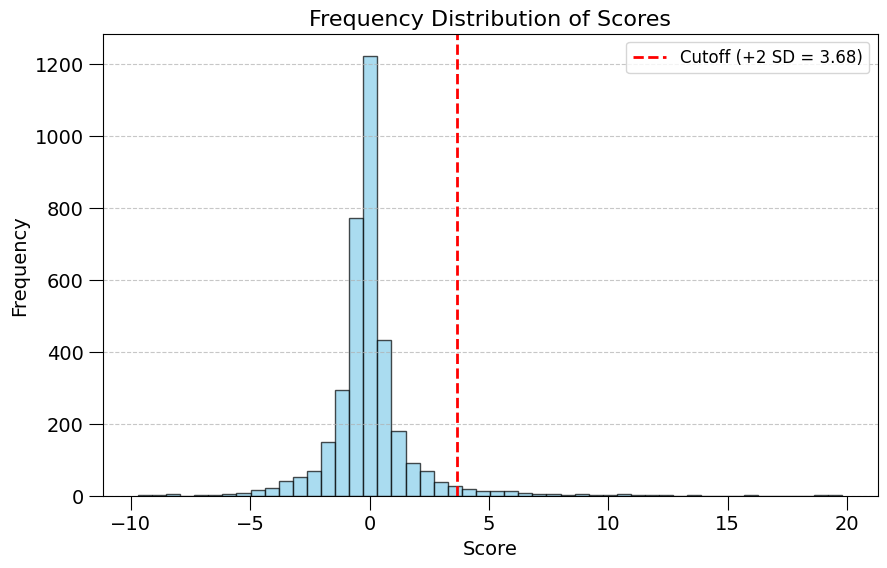

In [155]:
# Calculate mean and standard deviation of the 'score' column
mean_score = markergene_df['score'].mean()
std_score = markergene_df['score'].std()

# Calculate the +2 SD cutoff
cutoff = mean_score + 2 * std_score

print(f"Mean: {mean_score}, Standard Deviation: {std_score}")
print(f"Cutoff for significantly enriched scores: {cutoff}")

# Filter the DataFrame for significant scores
significant_scores_df = markergene_df[markergene_df['score'] > cutoff]

# Display significant scores
print(significant_scores_df)

plt.figure(figsize=(10, 6))
plt.hist(markergene_df['score'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(cutoff, color='red', linestyle='--', linewidth=2, label=f'Cutoff (+2 SD = {cutoff:.2f})')
plt.title('Frequency Distribution of Scores', fontsize=16)
plt.xlabel('Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



So for all clusters, the +2 STD cut off is 3.68. 
I will calculate this for each cluster individually to see if this is very variable by cluster. 

In [156]:
# Group the dataframe by 'cluster' and process each group
cluster_results = {}  # To store results for each cluster

for cluster, group in markergene_df.groupby('cluster'):
    # Calculate mean and standard deviation for the current cluster
    mean_score = group['score'].mean()
    std_score = group['score'].std()
    
    # Calculate the +2 SD cutoff
    cutoff = mean_score + 2 * std_score
    
    # Filter significant scores for the current cluster
    significant_scores = group[group['score'] > cutoff]
    
    # Store results
    cluster_results[cluster] = {
        'mean': mean_score,
        'std': std_score,
        'cutoff': cutoff,
        'significant_scores': significant_scores
    }
    
    # Print summary for this cluster
    print(f"Cluster: {cluster}")
    print(f"  Mean: {mean_score:.2f}")
    print(f"  Standard Deviation: {std_score:.2f}")
    print(f"  Cutoff (+2 SD): {cutoff:.2f}")
    print(f"  Significant Scores Count: {len(significant_scores)}")
    print()

# Combine all significant scores into a single DataFrame (optional)
all_significant_scores = pd.concat([res['significant_scores'] for res in cluster_results.values()])


Cluster: 0
  Mean: -0.32
  Standard Deviation: 1.92
  Cutoff (+2 SD): 3.51
  Significant Scores Count: 3

Cluster: 1
  Mean: -0.11
  Standard Deviation: 2.04
  Cutoff (+2 SD): 3.98
  Significant Scores Count: 6

Cluster: 10
  Mean: 0.03
  Standard Deviation: 1.54
  Cutoff (+2 SD): 3.12
  Significant Scores Count: 9

Cluster: 11
  Mean: -0.13
  Standard Deviation: 1.80
  Cutoff (+2 SD): 3.46
  Significant Scores Count: 5

Cluster: 12
  Mean: 0.12
  Standard Deviation: 1.92
  Cutoff (+2 SD): 3.96
  Significant Scores Count: 6

Cluster: 13
  Mean: 0.14
  Standard Deviation: 1.71
  Cutoff (+2 SD): 3.55
  Significant Scores Count: 6

Cluster: 14
  Mean: 0.08
  Standard Deviation: 1.56
  Cutoff (+2 SD): 3.20
  Significant Scores Count: 10

Cluster: 15
  Mean: 0.11
  Standard Deviation: 1.92
  Cutoff (+2 SD): 3.96
  Significant Scores Count: 6

Cluster: 16
  Mean: 0.20
  Standard Deviation: 1.76
  Cutoff (+2 SD): 3.72
  Significant Scores Count: 7

Cluster: 17
  Mean: 0.11
  Standard Deviatio

The scores are not very variable, they vary from 3.12-4.07
But I will apply these for each for the clusters to get my 'top genes' and see how many markers for each this gives me 

In [157]:
# Create an empty list to collect filtered data for each cluster
filtered_data = []

# Dictionary to store row counts for each cluster
cluster_row_counts = {}

# Loop through each cluster group
for cluster, group in markergene_df.groupby('cluster'):
    # Calculate mean and standard deviation for the current cluster
    mean_score = group['score'].mean()
    std_score = group['score'].std()
    
    # Calculate the +2 SD cutoff
    cutoff = mean_score + 2 * std_score
    
    # Filter the group for scores above the cutoff
    filtered_group = group[group['score'] > cutoff]
    
    # Append the filtered group to the list
    filtered_data.append(filtered_group)
    
    # Store the number of rows in the filtered group
    cluster_row_counts[cluster] = len(filtered_group)

# Combine all filtered groups into a single DataFrame
filtered_markergene_df = pd.concat(filtered_data)

# Reset index for clarity (optional)
filtered_markergene_df.reset_index(drop=True, inplace=True)

# Print the row counts for each cluster
print("Number of rows per cluster in the filtered DataFrame:")
for cluster, count in cluster_row_counts.items():
    print(f"Cluster {cluster}: {count} genes")

# Display the total number of rows in the filtered DataFrame
print(f"\nTotalfiltered marker genes: {len(filtered_markergene_df)}")

# Display the filtered DataFrame (optional)
print(filtered_markergene_df)


Number of rows per cluster in the filtered DataFrame:
Cluster 0: 3 genes
Cluster 1: 6 genes
Cluster 10: 9 genes
Cluster 11: 5 genes
Cluster 12: 6 genes
Cluster 13: 6 genes
Cluster 14: 10 genes
Cluster 15: 6 genes
Cluster 16: 7 genes
Cluster 17: 10 genes
Cluster 2: 5 genes
Cluster 3: 8 genes
Cluster 4: 7 genes
Cluster 5: 4 genes
Cluster 6: 8 genes
Cluster 7: 5 genes
Cluster 8: 3 genes
Cluster 9: 8 genes

Totalfiltered marker genes: 116
                   gene      score cluster
0    TraesCS4A02G256700   9.094888       0
1    TraesCS4B02G064000   6.216168       0
2    TraesCS3D02G284200   4.588726       0
3    TraesCS4D02G296400  13.337225       1
4    TraesCS6D02G220400   8.891061       1
..                  ...        ...     ...
111  TraesCS7B02G413900   5.830931       9
112  TraesCS7A02G175200   4.953066       9
113  TraesCS5A02G356100   4.799537       9
114  TraesCS2B02G399800   4.534127       9
115  TraesCS5A02G473800   3.859297       9

[116 rows x 3 columns]


### Now I want to annotate these markers with their names 

This will be used for Supplementary Table H, with added annotations applied by hand (including literature and label name) 

In [ ]:
annotation = pd.read_csv('annotated_names_12_24.csv').dropna()
annotation = annotation.rename(columns={'gene_id': 'gene'})

annotation_subset = annotation[['gene', 'annotated_name']]

# Merge filtered_markergene_df with the annotation_subset on the 'gene' column
filtered_markergene_df_annotated = filtered_markergene_df.merge(annotation_subset, on='gene', how = 'left')

filtered_markergene_df_annotated['annotated_name'] = filtered_markergene_df_annotated['annotated_name'].fillna('')

filtered_markergene_df_annotated

In [170]:
formatted_markergene_df = (
    filtered_markergene_df_annotated.drop(columns='score')
    .groupby('cluster')
    .agg({
        'gene': lambda x: ', '.join(filter(None, x)),  # Skip empty strings
        'annotated_name': lambda x: ', '.join(filter(None, x))  # Skip empty strings
    })
    .reset_index()
)

# Display the formatted DataFrame
formatted_markergene_df.to_csv("enrichmentanalysis/topenrichedgenes_domainnames.csv", index=False)
formatted_markergene_df

cluster                                               gene  \
0        0  TraesCS4A02G256700, TraesCS4B02G064000, TraesC...   
1        1  TraesCS4D02G296400, TraesCS6D02G220400, TraesC...   
2       10  TraesCS7A02G383800, TraesCS7D02G261600, TraesC...   
3       11  TraesCS7D02G246100, TraesCS3D02G284200, TraesC...   
4       12  TraesCS6A02G287300, TraesCS1A02G418200, TraesC...   
5       13  TraesCS6D02G220400, TraesCS1D02G162600, TraesC...   
6       14  TraesCS4D02G296400, TraesCS1D02G197300, TraesC...   
7       15  TraesCS6A02G259000, TraesCS2B02G464200, TraesC...   
8       16  TraesCS6A02G259000, TraesCS1D02G127700, TraesC...   
9       17  TraesCS6A02G259000, TraesCS7A02G383800, TraesC...   
10       2  TraesCS6D02G220400, TraesCS2B02G403100, TraesC...   
11       3  TraesCS1B02G042200, TraesCS4A02G256700, TraesC...   
12       4  TraesCS7A02G308400, TraesCS4D02G296400, TraesC...   
13       5  TraesCS3D02G284200, TraesCS1B02G042200, TraesC...   
14       6  TraesCS1B02G479300, TraesCS6A02G176400, TraesC...   
15       7  TraesCS6A02G259000, TraesCS4A02G256700, TraesC...   
16       8  TraesCS4D02G245300, TraesCS2B02G403100, TraesC...   
17       9  TraesCS4B02G064000, TraesCS6A02G313800, TraesC...   

                                       annotated_name  
0   TraesCS4A02G256700_TaKNOX5, TraesCS4B02G064000...  
1   TraesCS4D02G296400, TraesCS6D02G220400_TaYABBY...  
2   TraesCS7A02G383800_AP3_OsMADS16, TraesCS7D02G2...  
3   TraesCS7D02G246100_OsCUC3, TraesCS3D02G284200_...  
4   TraesCS6A02G287300_OsLEC1, TraesCS1A02G418200_...  
5   TraesCS6D02G220400_TaYABBY7D, TraesCS1D02G1626...  
6   TraesCS4D02G296400, TraesCS1D02G197300_OsROC3t...  
7   TraesCS6A02G259000_AGL6_OsMADS6, TraesCS2B02G4...  
8   TraesCS6A02G259000_AGL6_OsMADS6, TraesCS1D02G1...  
9   TraesCS6A02G259000_AGL6_OsMADS6, TraesCS7A02G3...  
10  TraesCS6D02G220400_TaYABBY7D, TraesCS2B02G4031...  
11  TraesCS1B02G042200_MT2, TraesCS4A02G256700_TaK...  
12  TraesCS7A02G308400_OsROC7t, TraesCS4D02G296400...  
13  TraesCS3D02G284200_OsMADS32, TraesCS1B02G04220...  
14  TraesCS1B02G479300, TraesCS6A02G176400_SRZ1, T...  
15  TraesCS6A02G259000_AGL6_OsMADS6, TraesCS4A02G2...  
16  TraesCS4D02G245300_TaYABBY4D, TraesCS2B02G4031...  
17  TraesCS4B02G064000_OsGIF3, TraesCS6A02G313800_...

## Creating high quality UMAPs and spatial plots for publication 

In [12]:
# Define custom colors for specific clusters
custom_cluster_colors = {
    '0': '#a70e62',
    '1': '#e10e3c',
    '2': '#f47140',
    '3': '#f0b932',
    '4' : '#ffd95a',
    '5': '#c2ed51',
    '6': '#8ed73d',
    '7': '#489c73',
    '8': '#1a8d83',
    '9': '#4915be',
    '10': '#2357d5',
    '11': '#fed2ff', 
    '12': '#6ecad5',
    '13': '#bd08f9',
    '14': '#886fc2',
    '15': '#e170c0',
    '16': '#ff33cc', 
    '17': '#e4a9e8'
}

default_color = 'white'

In [13]:
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['ytick.major.size'] = 10

### mapping late double ridge WT

In [14]:
# Filter to create a new AnnData object with only the sample 'VGN1e1'
adata_VGN1e1 = adata_spatial[adata_spatial.obs['dataset'] == 'VGN1e1'].copy()

adata_VGN1e1.obs.index = [index.split('-')[0] for index in adata_VGN1e1.obs.index]

# Convert adata_VGN1e1.obs to a dataframe and reset the index to make the index a column
adata_VGN1e1_df = adata_VGN1e1.obs.reset_index()

# Rename the index column if necessary (for example, to 'cell_id')
adata_VGN1e1_df = adata_VGN1e1_df.rename(columns={'index': 'cell_id'})


# Load segmentation data
segmentation_df = gpd.read_parquet("cell_segmentation/VGN1e_region1_output/cellpose2_micron_space_VGN1e1.parquet")

#filter segmentation data to only include high quality, analysed cells
#list the cell ids we want to include
adata_VGN1e1_df['cell_id'] = adata_VGN1e1_df['cell_id'].astype(str).str.strip()
cell_ids = adata_VGN1e1_df['cell_id'].tolist()
cell_ids = [cell_id.strip() for cell_id in cell_ids]

# Convert EntityID in filtered_segmentation_df to strings to match with cell_ids
filtered_segmentation_df = segmentation_df.copy()
filtered_segmentation_df['EntityID'] = filtered_segmentation_df['EntityID'].astype(str)

# Now filter based on matching values in cell_ids
filtered_segmentation_df = filtered_segmentation_df[filtered_segmentation_df['EntityID'].isin(cell_ids)]

#include cluster infomration into the dataframe
adata_VGN1e1_df = adata_VGN1e1.obs[['clusters']].copy()
adata_VGN1e1_df.index = adata_VGN1e1_df.index.astype(str)  # Ensure the index is a string if necessary
filtered_segmentation_df['EntityID'] = filtered_segmentation_df['EntityID'].astype(str)
filtered_segmentation_df = filtered_segmentation_df.merge(adata_VGN1e1_df, left_on='EntityID', right_index=True)
filtered_segmentation_df

ID             EntityID  ZIndex  \
48334  48334  2343479300017100075       1   
48829  48829  2343479300017100075       6   
48664  48664  2343479300017100075       0   
48499  48499  2343479300017100075       5   
48004  48004  2343479300017100075       2   
...      ...                  ...     ...   
28175  28175  2343479300098100014       2   
28195  28195  2343479300098100014       0   
28200  28200  2343479300098100014       6   
28185  28185  2343479300098100014       1   
28170  28170  2343479300098100014       3   

                                                Geometry ParentType ParentID  \
48334  MULTIPOLYGON (((3408.174 6460.388, 3408.210 64...       None     None   
48829  MULTIPOLYGON (((3408.174 6460.388, 3408.210 64...       None     None   
48664  MULTIPOLYGON (((3408.174 6460.388, 3408.210 64...       None     None   
48499  MULTIPOLYGON (((3408.174 6460.388, 3408.210 64...       None     None   
48004  MULTIPOLYGON (((3408.174 6460.388, 3408.210 64...       None     None   
...                                                  ...        ...      ...   
28175  MULTIPOLYGON (((4221.030 7741.360, 4222.109 77...       None     None   
28195  MULTIPOLYGON (((4221.030 7741.360, 4222.109 77...       None     None   
28200  MULTIPOLYGON (((4221.030 7741.360, 4222.109 77...       None     None   
28185  MULTIPOLYGON (((4221.030 7741.360, 4222.109 77...       None     None   
28170  MULTIPOLYGON (((4221.030 7741.360, 4222.109 77...       None     None   

       Type  ZLevel  Name clusters  
48334  cell     3.0  None        6  
48829  cell    10.5  None        6  
48664  cell     1.5  None        6  
48499  cell     9.0  None        6  
48004  cell     4.5  None        6  
...     ...     ...   ...      ...  
28175  cell     4.5  None       12  
28195  cell     1.5  None       12  
28200  cell    10.5  None       12  
28185  cell     3.0  None       12  
28170  cell     6.0  None       12  

[15463 rows x 10 columns]

In [15]:
# I need to look into the region min and max values so I know where to set the axes of graph

# Variables to track min and max x, y
min_x, min_y = float('inf'), float('inf')
max_x, max_y = float('-inf'), float('-inf')

# Iterate through the geometries
for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    
    if isinstance(shape, (Polygon, MultiPolygon)):
        # Get the bounding box of the shape
        bounds = shape.bounds  # Returns (min_x, min_y, max_x, max_y)
        min_x = min(min_x, bounds[0])
        min_y = min(min_y, bounds[1])
        max_x = max(max_x, bounds[2])
        max_y = max(max_y, bounds[3])

# Round to the nearest 1's place
min_x, min_y, max_x, max_y = round(min_x), round(min_y), round(max_x), round(max_y)

# Print the rounded min and max values for x and y
print(f"Min X: {min_x}, Max X: {max_x}")
print(f"Min Y: {min_y}, Max Y: {max_y}")


Min X: 3373, Max X: 4451
Min Y: 6363, Max Y: 7851


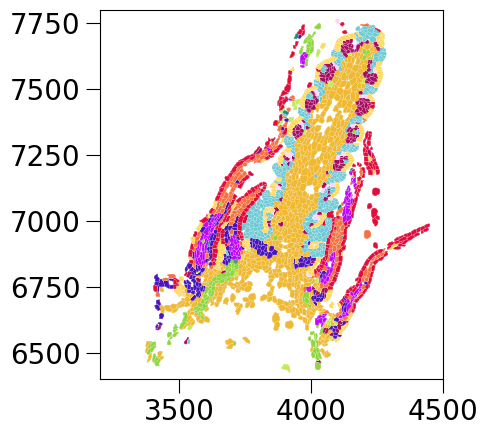

In [16]:
fig, ax = plt.subplots()
patches_list = []

for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    cluster = str(row['clusters'])  # Convert cluster to string to match custom colors dict keys
    
    # Assign color based on the custom mapping, with a default fallback
    color = custom_cluster_colors.get(cluster, default_color)

    if isinstance(shape, MultiPolygon):
        for poly in shape.geoms:
            patch = patches.Polygon(list(poly.exterior.coords), closed=True, facecolor=color, edgecolor='white', linewidth=0.1)
            patches_list.append(patch)
    elif isinstance(shape, Polygon):
        patch = patches.Polygon(list(shape.exterior.coords), closed=True, facecolor=color, edgecolor='white', linewidth=0.1)
        patches_list.append(patch)

# Set axis limits
ax.set_xlim([3200, 4500])
ax.set_ylim([6400, 7800])
ax.set_aspect('equal')

# Use PatchCollection to handle all patches
collection = PatchCollection(patches_list, match_original=True)
ax.add_collection(collection)
plt.show()

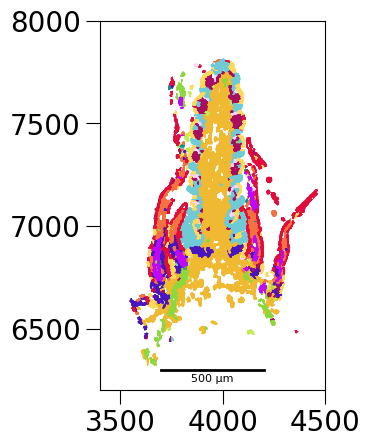

In [22]:
import numpy as np
from shapely.geometry import Polygon, MultiPolygon
from shapely.affinity import affine_transform
from matplotlib.lines import Line2D

# Ensure the original geometries are preserved
if 'Original_Geometry' not in filtered_segmentation_df.columns:
    filtered_segmentation_df['Original_Geometry'] = filtered_segmentation_df['Geometry']

# Define rotation angle in degrees
rotation_angle = 20
angle_rad = np.radians(rotation_angle)

# Calculate the rotation matrix components
cos_theta = np.cos(angle_rad)
sin_theta = np.sin(angle_rad)

# Get the centroid of the entire sample as the rotation origin
centroid_x = (min_x + max_x) / 2  # Use the previously computed min_x, max_x
centroid_y = (min_y + max_y) / 2  # Use the previously computed min_y, max_y

# Rotation matrix for Shapely's affine_transform (a, b, d, e, xoff, yoff)
rotation_matrix = [
    cos_theta, -sin_theta,  # a, b
    sin_theta, cos_theta,   # d, e
    centroid_x - cos_theta * centroid_x + sin_theta * centroid_y,  # xoff
    centroid_y - sin_theta * centroid_x - cos_theta * centroid_y   # yoff
]

# Rotate the original geometries
rotated_geometries = filtered_segmentation_df['Original_Geometry'].apply(lambda geom: affine_transform(geom, rotation_matrix))

# Update the dataframe with the rotated geometries
filtered_segmentation_df['Geometry'] = rotated_geometries

# Plot the rotated sample
fig, ax = plt.subplots()
patches_list = []

for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    cluster = str(row['clusters'])  # Convert cluster to string to match custom colors dict keys
    
    # Assign color based on the custom mapping, with a default fallback
    color = custom_cluster_colors.get(cluster, default_color)

    if isinstance(shape, MultiPolygon):
        for poly in shape.geoms:
            patch = patches.Polygon(list(poly.exterior.coords), closed=True, facecolor=color, edgecolor='white', linewidth=0.0)
            patches_list.append(patch)
    elif isinstance(shape, Polygon):
        patch = patches.Polygon(list(shape.exterior.coords), closed=True, facecolor=color, edgecolor='white', linewidth=0.0)
        patches_list.append(patch)

# Adjust axis limits as needed
ax.set_xlim([3400, 4500])  # Update if necessary after rotation
ax.set_ylim([6200, 8000])  # Update if necessary after rotation
ax.set_aspect('equal')

# Use PatchCollection to handle all patches
collection = PatchCollection(patches_list, match_original=True)
ax.add_collection(collection)

# Add the scale bar
scale_bar_length_microns = 500  # Length of scale bar in microns
scale_bar_x_start = 3700        # X-coordinate for the start of the scale bar
scale_bar_y_start = 6300        # Y-coordinate for the start of the scale bar
scale_bar_length_units = scale_bar_length_microns  # Assuming 1 unit = 1 micron

# Add scale bar as a line
scale_bar = Line2D(
    [scale_bar_x_start, scale_bar_x_start + scale_bar_length_units],
    [scale_bar_y_start, scale_bar_y_start],
    color="black",
    linewidth=2
)
ax.add_line(scale_bar)

# Add label for scale bar
ax.text(
    scale_bar_x_start + scale_bar_length_units / 2,
    scale_bar_y_start - 20,  # Adjust to place label below the bar
    f"{scale_bar_length_microns} µm",
    color="black",
    ha="center",
    va="top",
    fontsize=8
)

plt.savefig('leidenclustering/VGN1e1_domainmap_500scalebar.png', bbox_inches='tight', dpi=700, format='png', transparent=False)
plt.show()


In [19]:
### mapping late double ridge MUT

In [24]:
# Filter to create a new AnnData object with only the sample 'VGN1e9'
adata_VGN1e9 = adata_spatial[adata_spatial.obs['dataset'] == 'VGN1e9'].copy()

adata_VGN1e9.obs.index = [index.split('-')[0] for index in adata_VGN1e9.obs.index]

# Convert adata_VGN1e1.obs to a dataframe and reset the index to make the index a column
adata_VGN1e9_df = adata_VGN1e9.obs.reset_index()

# Rename the index column if necessary (for example, to 'cell_id')
adata_VGN1e9_df = adata_VGN1e9_df.rename(columns={'index': 'cell_id'})


# Load segmentation data
segmentation_df = gpd.read_parquet("cell_segmentation/VGN1e_region9_output/cellpose2_micron_space_VGN1e9.parquet")

#filter segmentation data to only include high quality, analysed cells
#list the cell ids we want to include
adata_VGN1e9_df['cell_id'] = adata_VGN1e9_df['cell_id'].astype(str).str.strip()
cell_ids = adata_VGN1e9_df['cell_id'].tolist()
cell_ids = [cell_id.strip() for cell_id in cell_ids]

# Convert EntityID in filtered_segmentation_df to strings to match with cell_ids
filtered_segmentation_df = segmentation_df.copy()
filtered_segmentation_df['EntityID'] = filtered_segmentation_df['EntityID'].astype(str)

# Now filter based on matching values in cell_ids
filtered_segmentation_df = filtered_segmentation_df[filtered_segmentation_df['EntityID'].isin(cell_ids)]

#include cluster infomration into the dataframe
adata_VGN1e9_df = adata_VGN1e9.obs[['clusters']].copy()
adata_VGN1e9_df.index = adata_VGN1e9_df.index.astype(str)  # Ensure the index is a string if necessary
filtered_segmentation_df['EntityID'] = filtered_segmentation_df['EntityID'].astype(str)
filtered_segmentation_df = filtered_segmentation_df.merge(adata_VGN1e9_df, left_on='EntityID', right_index=True)
filtered_segmentation_df

ID             EntityID  ZIndex  \
56991  56991  2655507000046100147       3   
57911  57911  2655507000046100147       5   
57451  57451  2655507000046100147       4   
58141  58141  2655507000046100147       0   
57681  57681  2655507000046100147       1   
...      ...                  ...     ...   
15423  15423  2655507000138100178       5   
15163  15163  2655507000138100178       3   
15358  15358  2655507000138100178       1   
15553  15553  2655507000138100178       6   
15488  15488  2655507000138100178       0   

                                                Geometry ParentType ParentID  \
56991  MULTIPOLYGON (((6828.874 8057.041, 6828.979 80...       None     None   
57911  MULTIPOLYGON (((6828.874 8057.041, 6828.979 80...       None     None   
57451  MULTIPOLYGON (((6828.874 8057.041, 6828.979 80...       None     None   
58141  MULTIPOLYGON (((6828.874 8057.041, 6828.979 80...       None     None   
57681  MULTIPOLYGON (((6828.874 8057.041, 6828.979 80...       None     None   
...                                                  ...        ...      ...   
15423  MULTIPOLYGON (((7305.041 9536.552, 7308.216 95...       None     None   
15163  MULTIPOLYGON (((7305.041 9536.552, 7308.216 95...       None     None   
15358  MULTIPOLYGON (((7305.041 9536.552, 7308.216 95...       None     None   
15553  MULTIPOLYGON (((7305.041 9536.552, 7308.216 95...       None     None   
15488  MULTIPOLYGON (((7305.041 9536.552, 7308.216 95...       None     None   

       Type  ZLevel  Name clusters  
56991  cell     6.0  None        6  
57911  cell     9.0  None        6  
57451  cell     7.5  None        6  
58141  cell     1.5  None        6  
57681  cell     3.0  None        6  
...     ...     ...   ...      ...  
15423  cell     9.0  None        0  
15163  cell     6.0  None        0  
15358  cell     3.0  None        0  
15553  cell    10.5  None        0  
15488  cell     1.5  None        0  

[10983 rows x 10 columns]

In [25]:
# I need to look into the region min and max values so I know where to set the axes of graph

# Variables to track min and max x, y
min_x, min_y = float('inf'), float('inf')
max_x, max_y = float('-inf'), float('-inf')

# Iterate through the geometries
for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    
    if isinstance(shape, (Polygon, MultiPolygon)):
        # Get the bounding box of the shape
        bounds = shape.bounds  # Returns (min_x, min_y, max_x, max_y)
        min_x = min(min_x, bounds[0])
        min_y = min(min_y, bounds[1])
        max_x = max(max_x, bounds[2])
        max_y = max(max_y, bounds[3])

# Round to the nearest 1's place
min_x, min_y, max_x, max_y = round(min_x), round(min_y), round(max_x), round(max_y)

# Print the rounded min and max values for x and y
print(f"Min X: {min_x}, Max X: {max_x}")
print(f"Min Y: {min_y}, Max Y: {max_y}")


Min X: 6525, Max X: 7400
Min Y: 7978, Max Y: 9548


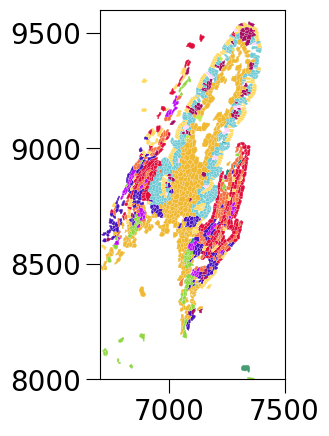

In [26]:
fig, ax = plt.subplots()
patches_list = []

for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    cluster = str(row['clusters'])  # Convert cluster to string to match custom colors dict keys
    
    # Assign color based on the custom mapping, with a default fallback
    color = custom_cluster_colors.get(cluster, default_color)

    if isinstance(shape, MultiPolygon):
        for poly in shape.geoms:
            patch = patches.Polygon(list(poly.exterior.coords), closed=True, facecolor=color, edgecolor='white', linewidth=0.1)
            patches_list.append(patch)
    elif isinstance(shape, Polygon):
        patch = patches.Polygon(list(shape.exterior.coords), closed=True, facecolor=color, edgecolor='white', linewidth=0.1)
        patches_list.append(patch)

# Set axis limits
ax.set_xlim([6700, 7500])
ax.set_ylim([8000, 9600])
ax.set_aspect('equal')

# Use PatchCollection to handle all patches
collection = PatchCollection(patches_list, match_original=True)
ax.add_collection(collection)

plt.show()

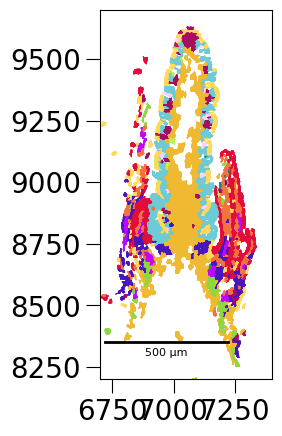

In [27]:
# Ensure the original geometries are preserved
if 'Original_Geometry' not in filtered_segmentation_df.columns:
    filtered_segmentation_df['Original_Geometry'] = filtered_segmentation_df['Geometry']

# Define rotation angle in degrees
rotation_angle = 20
angle_rad = np.radians(rotation_angle)

# Calculate the rotation matrix components
cos_theta = np.cos(angle_rad)
sin_theta = np.sin(angle_rad)

# Get the centroid of the entire sample as the rotation origin
centroid_x = (min_x + max_x) / 2  # Use the previously computed min_x, max_x
centroid_y = (min_y + max_y) / 2  # Use the previously computed min_y, max_y

# Rotation matrix for Shapely's affine_transform (a, b, d, e, xoff, yoff)
rotation_matrix = [
    cos_theta, -sin_theta,  # a, b
    sin_theta, cos_theta,   # d, e
    centroid_x - cos_theta * centroid_x + sin_theta * centroid_y,  # xoff
    centroid_y - sin_theta * centroid_x - cos_theta * centroid_y   # yoff
]

# Rotate the original geometries
rotated_geometries = filtered_segmentation_df['Original_Geometry'].apply(lambda geom: affine_transform(geom, rotation_matrix))

# Update the dataframe with the rotated geometries
filtered_segmentation_df['Geometry'] = rotated_geometries

# Plot the rotated sample
fig, ax = plt.subplots()
patches_list = []

for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    cluster = str(row['clusters'])  # Convert cluster to string to match custom colors dict keys
    
    # Assign color based on the custom mapping, with a default fallback
    color = custom_cluster_colors.get(cluster, default_color)

    if isinstance(shape, MultiPolygon):
        for poly in shape.geoms:
            patch = patches.Polygon(list(poly.exterior.coords), closed=True, facecolor=color, edgecolor='white', linewidth=0.0)
            patches_list.append(patch)
    elif isinstance(shape, Polygon):
        patch = patches.Polygon(list(shape.exterior.coords), closed=True, facecolor=color, edgecolor='white', linewidth=0.0)
        patches_list.append(patch)

# Adjust axis limits as needed
ax.set_xlim([6700, 7400])
ax.set_ylim([8200, 9700])
ax.set_aspect('equal')

# Use PatchCollection to handle all patches
collection = PatchCollection(patches_list, match_original=True)
ax.add_collection(collection)

# Add the scale bar
scale_bar_length_microns = 500  # Length of scale bar in microns
scale_bar_x_start = 6720        # X-coordinate for the start of the scale bar
scale_bar_y_start = 8350       # Y-coordinate for the start of the scale bar
scale_bar_length_units = scale_bar_length_microns  # Assuming 1 unit = 1 micron

# Add scale bar as a line
scale_bar = Line2D(
    [scale_bar_x_start, scale_bar_x_start + scale_bar_length_units],
    [scale_bar_y_start, scale_bar_y_start],
    color="black",
    linewidth=2
)
ax.add_line(scale_bar)

# Add label for scale bar
ax.text(
    scale_bar_x_start + scale_bar_length_units / 2,
    scale_bar_y_start - 20,  # Adjust to place label below the bar
    f"{scale_bar_length_microns} µm",
    color="black",
    ha="center",
    va="top",
    fontsize=8
)

plt.savefig('leidenclustering/VGN1e9_domainmap_500scalebar.png', dpi=700, bbox_inches='tight', format='png', transparent=False)
plt.show()


### mapping lemma primordia WT

In [28]:
# Filter to create a new AnnData object with only the sample 'VGN1b6'
adata_VGN1b6 = adata_spatial[adata_spatial.obs['dataset'] == 'VGN1b6'].copy()

adata_VGN1b6.obs.index = [index.split('-')[0] for index in adata_VGN1b6.obs.index]

# Convert adata_VGN1e1.obs to a dataframe and reset the index to make the index a column
adata_VGN1b6_df = adata_VGN1b6.obs.reset_index()

# Rename the index column if necessary (for example, to 'cell_id')
adata_VGN1b6_df = adata_VGN1b6_df.rename(columns={'index': 'cell_id'})


# Load segmentation data
segmentation_df = gpd.read_parquet("cell_segmentation/VGN1b_region6_output/cellpose2_micron_space_VGN1b6.parquet")

#filter segmentation data to only include high quality, analysed cells
#list the cell ids we want to include
adata_VGN1b6_df['cell_id'] = adata_VGN1b6_df['cell_id'].astype(str).str.strip()
cell_ids = adata_VGN1b6_df['cell_id'].tolist()
cell_ids = [cell_id.strip() for cell_id in cell_ids]

# Convert EntityID in filtered_segmentation_df to strings to match with cell_ids
filtered_segmentation_df = segmentation_df.copy()
filtered_segmentation_df['EntityID'] = filtered_segmentation_df['EntityID'].astype(str)

# Now filter based on matching values in cell_ids
filtered_segmentation_df = filtered_segmentation_df[filtered_segmentation_df['EntityID'].isin(cell_ids)]

#include cluster infomration into the dataframe
adata_VGN1b6_df = adata_VGN1b6.obs[['clusters']].copy()
adata_VGN1b6_df.index = adata_VGN1b6_df.index.astype(str)  # Ensure the index is a string if necessary
filtered_segmentation_df['EntityID'] = filtered_segmentation_df['EntityID'].astype(str)
filtered_segmentation_df = filtered_segmentation_df.merge(adata_VGN1b6_df, left_on='EntityID', right_index=True)
filtered_segmentation_df

ID             EntityID  ZIndex  \
18274  18274  2293012600006100168       1   
17778  17778  2293012600006100168       2   
18770  18770  2293012600006100168       0   
17530  17530  2293012600006100168       3   
19018  19018  2293012600006100168       6   
...      ...                  ...     ...   
62520  62520  2293012600036100142       6   
61842  61842  2293012600036100142       3   
61955  61955  2293012600036100142       2   
62294  62294  2293012600036100142       5   
62068  62068  2293012600036100142       4   

                                                Geometry ParentType ParentID  \
18274  MULTIPOLYGON (((5555.024 4413.845, 5555.399 44...       None     None   
17778  MULTIPOLYGON (((5555.024 4413.845, 5555.399 44...       None     None   
18770  MULTIPOLYGON (((5555.024 4413.845, 5555.399 44...       None     None   
17530  MULTIPOLYGON (((5555.024 4413.845, 5555.399 44...       None     None   
19018  MULTIPOLYGON (((5555.024 4413.845, 5555.399 44...       None     None   
...                                                  ...        ...      ...   
62520  MULTIPOLYGON (((5452.244 6030.988, 5452.287 60...       None     None   
61842  MULTIPOLYGON (((5452.244 6030.988, 5452.287 60...       None     None   
61955  MULTIPOLYGON (((5452.244 6030.988, 5452.287 60...       None     None   
62294  MULTIPOLYGON (((5452.244 6030.988, 5452.287 60...       None     None   
62068  MULTIPOLYGON (((5452.244 6030.988, 5452.287 60...       None     None   

       Type  ZLevel  Name clusters  
18274  cell     3.0  None        4  
17778  cell     4.5  None        4  
18770  cell     1.5  None        4  
17530  cell     6.0  None        4  
19018  cell    10.5  None        4  
...     ...     ...   ...      ...  
62520  cell    10.5  None        9  
61842  cell     6.0  None        9  
61955  cell     4.5  None        9  
62294  cell     9.0  None        9  
62068  cell     7.5  None        9  

[20272 rows x 10 columns]

In [29]:
# I need to look into the region min and max values so I know where to set the axes of graph

# Variables to track min and max x, y
min_x, min_y = float('inf'), float('inf')
max_x, max_y = float('-inf'), float('-inf')

# Iterate through the geometries
for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    
    if isinstance(shape, (Polygon, MultiPolygon)):
        # Get the bounding box of the shape
        bounds = shape.bounds  # Returns (min_x, min_y, max_x, max_y)
        min_x = min(min_x, bounds[0])
        min_y = min(min_y, bounds[1])
        max_x = max(max_x, bounds[2])
        max_y = max(max_y, bounds[3])

# Round to the nearest 1's place
min_x, min_y, max_x, max_y = round(min_x), round(min_y), round(max_x), round(max_y)

# Print the rounded min and max values for x and y
print(f"Min X: {min_x}, Max X: {max_x}")
print(f"Min Y: {min_y}, Max Y: {max_y}")


Min X: 5003, Max X: 5796
Min Y: 4333, Max Y: 6075


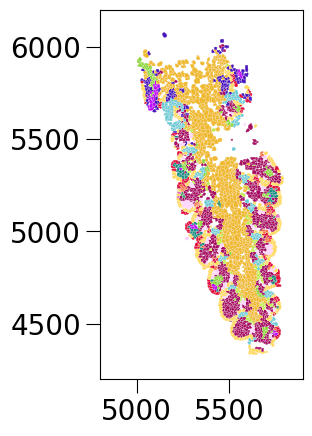

In [30]:
fig, ax = plt.subplots()
patches_list = []

for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    cluster = str(row['clusters'])  # Convert cluster to string to match custom colors dict keys
    
    # Assign color based on the custom mapping, with a default fallback
    color = custom_cluster_colors.get(cluster, default_color)

    if isinstance(shape, MultiPolygon):
        for poly in shape.geoms:
            patch = patches.Polygon(list(poly.exterior.coords), closed=True, facecolor=color, edgecolor='white', linewidth=0.1)
            patches_list.append(patch)
    elif isinstance(shape, Polygon):
        patch = patches.Polygon(list(shape.exterior.coords), closed=True, facecolor=color, edgecolor='white', linewidth=0.1)
        patches_list.append(patch)

# Set axis limits
ax.set_xlim([4800, 5900])
ax.set_ylim([4200, 6200])
ax.set_aspect('equal')

# Use PatchCollection to handle all patches
collection = PatchCollection(patches_list, match_original=True)
ax.add_collection(collection)

plt.show()

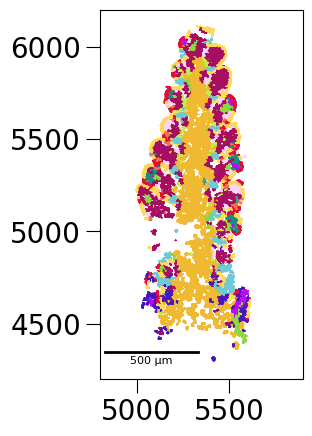

In [31]:
# Ensure the original geometries are preserved
if 'Original_Geometry' not in filtered_segmentation_df.columns:
    filtered_segmentation_df['Original_Geometry'] = filtered_segmentation_df['Geometry']

# Define rotation angle in degrees
rotation_angle = 165
angle_rad = np.radians(rotation_angle)

# Calculate the rotation matrix components
cos_theta = np.cos(angle_rad)
sin_theta = np.sin(angle_rad)

# Get the centroid of the entire sample as the rotation origin
centroid_x = (min_x + max_x) / 2  # Use the previously computed min_x, max_x
centroid_y = (min_y + max_y) / 2  # Use the previously computed min_y, max_y

# Rotation matrix for Shapely's affine_transform (a, b, d, e, xoff, yoff)
rotation_matrix = [
    cos_theta, -sin_theta,  # a, b
    sin_theta, cos_theta,   # d, e
    centroid_x - cos_theta * centroid_x + sin_theta * centroid_y,  # xoff
    centroid_y - sin_theta * centroid_x - cos_theta * centroid_y   # yoff
]

# Rotate the original geometries
rotated_geometries = filtered_segmentation_df['Original_Geometry'].apply(lambda geom: affine_transform(geom, rotation_matrix))

# Update the dataframe with the rotated geometries
filtered_segmentation_df['Geometry'] = rotated_geometries

# Plot the rotated sample
fig, ax = plt.subplots()
patches_list = []

for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    cluster = str(row['clusters'])  # Convert cluster to string to match custom colors dict keys
    
    # Assign color based on the custom mapping, with a default fallback
    color = custom_cluster_colors.get(cluster, default_color)

    if isinstance(shape, MultiPolygon):
        for poly in shape.geoms:
            patch = patches.Polygon(list(poly.exterior.coords), closed=True, facecolor=color, edgecolor='white', linewidth=0.0)
            patches_list.append(patch)
    elif isinstance(shape, Polygon):
        patch = patches.Polygon(list(shape.exterior.coords), closed=True, facecolor=color, edgecolor='white', linewidth=0.0)
        patches_list.append(patch)

# Adjust axis limits as needed
ax.set_xlim([4800, 5900])
ax.set_ylim([4200, 6200])
ax.set_aspect('equal')

# Use PatchCollection to handle all patches
collection = PatchCollection(patches_list, match_original=True)
ax.add_collection(collection)

# Add the scale bar
scale_bar_length_microns = 500  # Length of scale bar in microns
scale_bar_x_start = 4830        # X-coordinate for the start of the scale bar
scale_bar_y_start = 4350       # Y-coordinate for the start of the scale bar
scale_bar_length_units = scale_bar_length_microns  # Assuming 1 unit = 1 micron

# Add scale bar as a line
scale_bar = Line2D(
    [scale_bar_x_start, scale_bar_x_start + scale_bar_length_units],
    [scale_bar_y_start, scale_bar_y_start],
    color="black",
    linewidth=2
)
ax.add_line(scale_bar)

# Add label for scale bar
ax.text(
    scale_bar_x_start + scale_bar_length_units / 2,
    scale_bar_y_start - 20,  # Adjust to place label below the bar
    f"{scale_bar_length_microns} µm",
    color="black",
    ha="center",
    va="top",
    fontsize=8
)

plt.savefig('leidenclustering/VGN1b6_domainmap_500scalebar.png', dpi=1000, bbox_inches='tight', format='png', transparent=False)
plt.show()


I also want to make a domain map for the specific ridges 

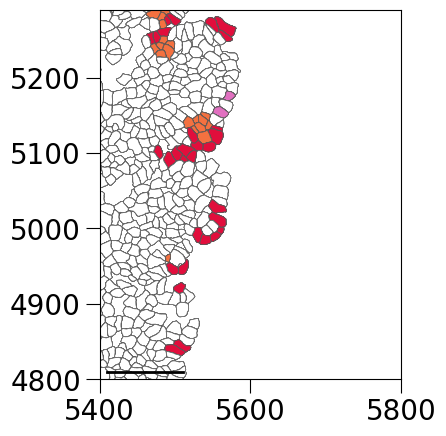

In [33]:
# Define custom colors for specific clusters
custom_cluster_colors2 = {
    '1': '#e10e3c',
    '2': '#f47140',
    '15': '#e170c0'
}

# Ensure the original geometries are preserved
if 'Original_Geometry' not in filtered_segmentation_df.columns:
    filtered_segmentation_df['Original_Geometry'] = filtered_segmentation_df['Geometry']

# Define rotation angle in degrees
rotation_angle = 165
angle_rad = np.radians(rotation_angle)

# Calculate the rotation matrix components
cos_theta = np.cos(angle_rad)
sin_theta = np.sin(angle_rad)

# Get the centroid of the entire sample as the rotation origin
centroid_x = (min_x + max_x) / 2  # Use the previously computed min_x, max_x
centroid_y = (min_y + max_y) / 2  # Use the previously computed min_y, max_y

# Rotation matrix for Shapely's affine_transform (a, b, d, e, xoff, yoff)
rotation_matrix = [
    cos_theta, -sin_theta,  # a, b
    sin_theta, cos_theta,   # d, e
    centroid_x - cos_theta * centroid_x + sin_theta * centroid_y,  # xoff
    centroid_y - sin_theta * centroid_x - cos_theta * centroid_y   # yoff
]

# Rotate the original geometries
rotated_geometries = filtered_segmentation_df['Original_Geometry'].apply(lambda geom: affine_transform(geom, rotation_matrix))

# Update the dataframe with the rotated geometries
filtered_segmentation_df['Geometry'] = rotated_geometries

# Plot the rotated sample
fig, ax = plt.subplots()
patches_list = []

for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    cluster = str(row['clusters'])  # Convert cluster to string to match custom colors dict keys
    
    # Assign color based on the custom mapping, with a default fallback
    color = custom_cluster_colors2.get(cluster, default_color)

    if isinstance(shape, MultiPolygon):
        for poly in shape.geoms:
            patch = patches.Polygon(list(poly.exterior.coords), closed=True, facecolor=color, edgecolor='#595959', linewidth=0.5)
            patches_list.append(patch)
    elif isinstance(shape, Polygon):
        patch = patches.Polygon(list(shape.exterior.coords), closed=True, facecolor=color, edgecolor='#595959', linewidth=0.5)
        patches_list.append(patch)

# Adjust axis limits as needed
ax.set_xlim([5400, 5800])
ax.set_ylim([4800, 5290])
ax.set_aspect('equal')

# Use PatchCollection to handle all patches
collection = PatchCollection(patches_list, match_original=True)
ax.add_collection(collection)

# Add the scale bar
scale_bar_length_microns = 100  # Length of scale bar in microns
scale_bar_x_start = 5410      # X-coordinate for the start of the scale bar
scale_bar_y_start = 4810       # Y-coordinate for the start of the scale bar
scale_bar_length_units = scale_bar_length_microns  # Assuming 1 unit = 1 micron

# Add scale bar as a line
scale_bar = Line2D(
    [scale_bar_x_start, scale_bar_x_start + scale_bar_length_units],
    [scale_bar_y_start, scale_bar_y_start],
    color="black",
    linewidth=2
)
ax.add_line(scale_bar)

plt.savefig('leidenclustering/VGN1b6_spikelettissues_100scalebar.png', dpi=700, bbox_inches='tight', format='png', transparent=False)
plt.show()


### mapping lemma primordia MUT

In [34]:
# Filter to create a new AnnData object with only the sample 'VGN1b8'
adata_VGN1b8 = adata_spatial[adata_spatial.obs['dataset'] == 'VGN1b8'].copy()

adata_VGN1b8.obs.index = [index.split('-')[0] for index in adata_VGN1b8.obs.index]

# Convert adata_VGN1e1.obs to a dataframe and reset the index to make the index a column
adata_VGN1b8_df = adata_VGN1b8.obs.reset_index()

# Rename the index column if necessary (for example, to 'cell_id')
adata_VGN1b8_df = adata_VGN1b8_df.rename(columns={'index': 'cell_id'})


# Load segmentation data
segmentation_df = gpd.read_parquet("cell_segmentation/VGN1b_region8_output/cellpose2_micron_space_VGN1b8.parquet")

#filter segmentation data to only include high quality, analysed cells
#list the cell ids we want to include
adata_VGN1b8_df['cell_id'] = adata_VGN1b8_df['cell_id'].astype(str).str.strip()
cell_ids = adata_VGN1b8_df['cell_id'].tolist()
cell_ids = [cell_id.strip() for cell_id in cell_ids]

# Convert EntityID in filtered_segmentation_df to strings to match with cell_ids
filtered_segmentation_df = segmentation_df.copy()
filtered_segmentation_df['EntityID'] = filtered_segmentation_df['EntityID'].astype(str)

# Now filter based on matching values in cell_ids
filtered_segmentation_df = filtered_segmentation_df[filtered_segmentation_df['EntityID'].isin(cell_ids)]

#include cluster infomration into the dataframe
adata_VGN1b8_df = adata_VGN1b8.obs[['clusters']].copy()
adata_VGN1b8_df.index = adata_VGN1b8_df.index.astype(str)  # Ensure the index is a string if necessary
filtered_segmentation_df['EntityID'] = filtered_segmentation_df['EntityID'].astype(str)
filtered_segmentation_df = filtered_segmentation_df.merge(adata_VGN1b8_df, left_on='EntityID', right_index=True)
filtered_segmentation_df

ID             EntityID  ZIndex  \
43190  43190  2654750700021100077       2   
44086  44086  2654750700021100077       0   
44310  44310  2654750700021100077       6   
43414  43414  2654750700021100077       4   
43638  43638  2654750700021100077       1   
...      ...                  ...     ...   
16813  16813  2654750700061100059       0   
16783  16783  2654750700061100059       5   
16663  16663  2654750700061100059       3   
16723  16723  2654750700061100059       4   
16843  16843  2654750700061100059       6   

                                                Geometry ParentType ParentID  \
43190  MULTIPOLYGON (((1641.195 6262.854, 1641.434 62...       None     None   
44086  MULTIPOLYGON (((1641.195 6262.854, 1641.434 62...       None     None   
44310  MULTIPOLYGON (((1641.195 6262.854, 1641.434 62...       None     None   
43414  MULTIPOLYGON (((1641.195 6262.854, 1641.434 62...       None     None   
43638  MULTIPOLYGON (((1641.195 6262.854, 1641.434 62...       None     None   
...                                                  ...        ...      ...   
16813  MULTIPOLYGON (((1407.301 7467.331, 1407.942 74...       None     None   
16783  MULTIPOLYGON (((1407.301 7467.331, 1407.942 74...       None     None   
16663  MULTIPOLYGON (((1407.301 7467.331, 1407.942 74...       None     None   
16723  MULTIPOLYGON (((1407.301 7467.331, 1407.942 74...       None     None   
16843  MULTIPOLYGON (((1407.301 7467.331, 1407.942 74...       None     None   

       Type  ZLevel  Name clusters  
43190  cell     4.5  None        4  
44086  cell     1.5  None        4  
44310  cell    10.5  None        4  
43414  cell     7.5  None        4  
43638  cell     3.0  None        4  
...     ...     ...   ...      ...  
16813  cell     1.5  None        9  
16783  cell     9.0  None        9  
16663  cell     6.0  None        9  
16723  cell     7.5  None        9  
16843  cell    10.5  None        9  

[14749 rows x 10 columns]

In [35]:
# I need to look into the region min and max values so I know where to set the axes of graph

# Variables to track min and max x, y
min_x, min_y = float('inf'), float('inf')
max_x, max_y = float('-inf'), float('-inf')

# Iterate through the geometries
for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    
    if isinstance(shape, (Polygon, MultiPolygon)):
        # Get the bounding box of the shape
        bounds = shape.bounds  # Returns (min_x, min_y, max_x, max_y)
        min_x = min(min_x, bounds[0])
        min_y = min(min_y, bounds[1])
        max_x = max(max_x, bounds[2])
        max_y = max(max_y, bounds[3])

# Round to the nearest 1's place
min_x, min_y, max_x, max_y = round(min_x), round(min_y), round(max_x), round(max_y)

# Print the rounded min and max values for x and y
print(f"Min X: {min_x}, Max X: {max_x}")
print(f"Min Y: {min_y}, Max Y: {max_y}")


Min X: 884, Max X: 1809
Min Y: 6243, Max Y: 7527


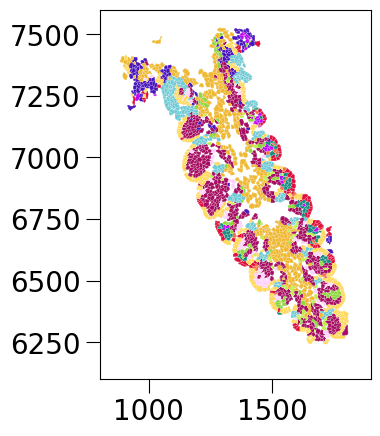

In [36]:
fig, ax = plt.subplots()
patches_list = []

for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    cluster = str(row['clusters'])  # Convert cluster to string to match custom colors dict keys
    
    # Assign color based on the custom mapping, with a default fallback
    color = custom_cluster_colors.get(cluster, default_color)

    if isinstance(shape, MultiPolygon):
        for poly in shape.geoms:
            patch = patches.Polygon(list(poly.exterior.coords), closed=True, facecolor=color, edgecolor='white', linewidth=0.1)
            patches_list.append(patch)
    elif isinstance(shape, Polygon):
        patch = patches.Polygon(list(shape.exterior.coords), closed=True, facecolor=color, edgecolor='white', linewidth=0.1)
        patches_list.append(patch)

# Set axis limits
ax.set_xlim([800, 1900])
ax.set_ylim([6100, 7600])
ax.set_aspect('equal')

# Use PatchCollection to handle all patches
collection = PatchCollection(patches_list, match_original=True)
ax.add_collection(collection)

plt.show()

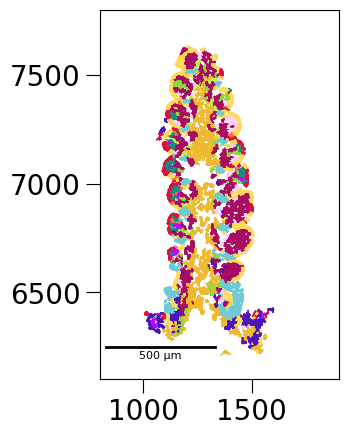

In [37]:
# Ensure the original geometries are preserved
if 'Original_Geometry' not in filtered_segmentation_df.columns:
    filtered_segmentation_df['Original_Geometry'] = filtered_segmentation_df['Geometry']

# Define rotation angle in degrees
rotation_angle = 155
angle_rad = np.radians(rotation_angle)

# Calculate the rotation matrix components
cos_theta = np.cos(angle_rad)
sin_theta = np.sin(angle_rad)

# Get the centroid of the entire sample as the rotation origin
centroid_x = (min_x + max_x) / 2  # Use the previously computed min_x, max_x
centroid_y = (min_y + max_y) / 2  # Use the previously computed min_y, max_y

# Rotation matrix for Shapely's affine_transform (a, b, d, e, xoff, yoff)
rotation_matrix = [
    cos_theta, -sin_theta,  # a, b
    sin_theta, cos_theta,   # d, e
    centroid_x - cos_theta * centroid_x + sin_theta * centroid_y,  # xoff
    centroid_y - sin_theta * centroid_x - cos_theta * centroid_y   # yoff
]

# Rotate the original geometries
rotated_geometries = filtered_segmentation_df['Original_Geometry'].apply(lambda geom: affine_transform(geom, rotation_matrix))

# Update the dataframe with the rotated geometries
filtered_segmentation_df['Geometry'] = rotated_geometries

# Plot the rotated sample
fig, ax = plt.subplots()
patches_list = []

for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    cluster = str(row['clusters'])  # Convert cluster to string to match custom colors dict keys
    
    # Assign color based on the custom mapping, with a default fallback
    color = custom_cluster_colors.get(cluster, default_color)

    if isinstance(shape, MultiPolygon):
        for poly in shape.geoms:
            patch = patches.Polygon(list(poly.exterior.coords), closed=True, facecolor=color, edgecolor='white', linewidth=0.0)
            patches_list.append(patch)
    elif isinstance(shape, Polygon):
        patch = patches.Polygon(list(shape.exterior.coords), closed=True, facecolor=color, edgecolor='white', linewidth=0.0)
        patches_list.append(patch)

# Adjust axis limits as needed
ax.set_xlim([800, 1900])
ax.set_ylim([6100, 7800])
ax.set_aspect('equal')

# Use PatchCollection to handle all patches
collection = PatchCollection(patches_list, match_original=True)
ax.add_collection(collection)

# Add the scale bar
scale_bar_length_microns = 500  # Length of scale bar in microns
scale_bar_x_start = 830        # X-coordinate for the start of the scale bar
scale_bar_y_start = 6250       # Y-coordinate for the start of the scale bar
scale_bar_length_units = scale_bar_length_microns  # Assuming 1 unit = 1 micron

# Add scale bar as a line
scale_bar = Line2D(
    [scale_bar_x_start, scale_bar_x_start + scale_bar_length_units],
    [scale_bar_y_start, scale_bar_y_start],
    color="black",
    linewidth=2
)
ax.add_line(scale_bar)

# Add label for scale bar
ax.text(
    scale_bar_x_start + scale_bar_length_units / 2,
    scale_bar_y_start - 20,  # Adjust to place label below the bar
    f"{scale_bar_length_microns} µm",
    color="black",
    ha="center",
    va="top",
    fontsize=8
)

plt.savefig('leidenclustering/VGN1b8_domainmap_500scalebar.png', dpi=1000, bbox_inches='tight', format='png', transparent=True)
plt.show()


### mapping terminal spikelet WT

In [38]:
# Filter to create a new AnnData object with only the sample 'VGN1b8'
adata_VGN1a6 = adata_spatial[adata_spatial.obs['dataset'] == 'VGN1a6'].copy()

adata_VGN1a6.obs.index = [index.split('-')[0] for index in adata_VGN1a6.obs.index]

# Convert adata_VGN1e1.obs to a dataframe and reset the index to make the index a column
adata_VGN1a6_df = adata_VGN1a6.obs.reset_index()

# Rename the index column if necessary (for example, to 'cell_id')
adata_VGN1a6_df = adata_VGN1a6_df.rename(columns={'index': 'cell_id'})


# Load segmentation data
segmentation_df = gpd.read_parquet("cell_segmentation/VGN1a_region6_output/cellpose2_micron_space_VGN1a6.parquet")

#filter segmentation data to only include high quality, analysed cells
#list the cell ids we want to include
adata_VGN1a6_df['cell_id'] = adata_VGN1a6_df['cell_id'].astype(str).str.strip()
cell_ids = adata_VGN1a6_df['cell_id'].tolist()
cell_ids = [cell_id.strip() for cell_id in cell_ids]

# Convert EntityID in filtered_segmentation_df to strings to match with cell_ids
filtered_segmentation_df = segmentation_df.copy()
filtered_segmentation_df['EntityID'] = filtered_segmentation_df['EntityID'].astype(str)

# Now filter based on matching values in cell_ids
filtered_segmentation_df = filtered_segmentation_df[filtered_segmentation_df['EntityID'].isin(cell_ids)]

#include cluster infomration into the dataframe
adata_VGN1a6_df = adata_VGN1a6.obs[['clusters']].copy()
adata_VGN1a6_df.index = adata_VGN1a6_df.index.astype(str)  # Ensure the index is a string if necessary
filtered_segmentation_df['EntityID'] = filtered_segmentation_df['EntityID'].astype(str)
filtered_segmentation_df = filtered_segmentation_df.merge(adata_VGN1a6_df, left_on='EntityID', right_index=True)
filtered_segmentation_df

ID             EntityID  ZIndex  \
14985  14985  2305551000002100247       6   
14772  14772  2305551000002100247       0   
14346  14346  2305551000002100247       1   
13920  13920  2305551000002100247       2   
14133  14133  2305551000002100247       4   
...      ...                  ...     ...   
12713  12713  2305551000055100230       2   
12608  12608  2305551000055100230       3   
13133  13133  2305551000055100230       0   
13238  13238  2305551000055100230       6   
13028  13028  2305551000055100230       5   

                                                Geometry ParentType ParentID  \
14985  MULTIPOLYGON (((740.840 5156.623, 742.057 5157...       None     None   
14772  MULTIPOLYGON (((740.840 5156.623, 742.057 5157...       None     None   
14346  MULTIPOLYGON (((740.840 5156.623, 742.057 5157...       None     None   
13920  MULTIPOLYGON (((740.840 5156.623, 742.057 5157...       None     None   
14133  MULTIPOLYGON (((740.840 5156.623, 742.057 5157...       None     None   
...                                                  ...        ...      ...   
12713  MULTIPOLYGON (((311.576 7442.294, 316.129 7442...       None     None   
12608  MULTIPOLYGON (((311.576 7442.294, 316.129 7442...       None     None   
13133  MULTIPOLYGON (((311.576 7442.294, 316.129 7442...       None     None   
13238  MULTIPOLYGON (((311.576 7442.294, 316.129 7442...       None     None   
13028  MULTIPOLYGON (((311.576 7442.294, 316.129 7442...       None     None   

       Type  ZLevel  Name clusters  
14985  cell    10.5  None        0  
14772  cell     1.5  None        0  
14346  cell     3.0  None        0  
13920  cell     4.5  None        0  
14133  cell     7.5  None        0  
...     ...     ...   ...      ...  
12713  cell     4.5  None        1  
12608  cell     6.0  None        1  
13133  cell     1.5  None        1  
13238  cell    10.5  None        1  
13028  cell     9.0  None        1  

[37835 rows x 10 columns]

In [39]:
# I need to look into the region min and max values so I know where to set the axes of graph

# Variables to track min and max x, y
min_x, min_y = float('inf'), float('inf')
max_x, max_y = float('-inf'), float('-inf')

# Iterate through the geometries
for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    
    if isinstance(shape, (Polygon, MultiPolygon)):
        # Get the bounding box of the shape
        bounds = shape.bounds  # Returns (min_x, min_y, max_x, max_y)
        min_x = min(min_x, bounds[0])
        min_y = min(min_y, bounds[1])
        max_x = max(max_x, bounds[2])
        max_y = max(max_y, bounds[3])

# Round to the nearest 1's place
min_x, min_y, max_x, max_y = round(min_x), round(min_y), round(max_x), round(max_y)

# Print the rounded min and max values for x and y
print(f"Min X: {min_x}, Max X: {max_x}")
print(f"Min Y: {min_y}, Max Y: {max_y}")


Min X: 178, Max X: 1475
Min Y: 5150, Max Y: 7524


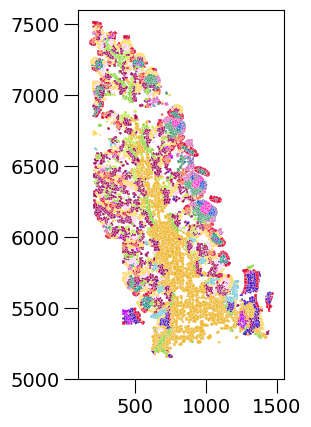

In [58]:
fig, ax = plt.subplots()
patches_list = []

for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    cluster = str(row['clusters'])  # Convert cluster to string to match custom colors dict keys
    
    # Assign color based on the custom mapping, with a default fallback
    color = custom_cluster_colors.get(cluster, default_color)

    if isinstance(shape, MultiPolygon):
        for poly in shape.geoms:
            patch = patches.Polygon(list(poly.exterior.coords), closed=True, facecolor=color, edgecolor='white', linewidth=0.1)
            patches_list.append(patch)
    elif isinstance(shape, Polygon):
        patch = patches.Polygon(list(shape.exterior.coords), closed=True, facecolor=color, edgecolor='white', linewidth=0.1)
        patches_list.append(patch)


# Set axis limits
ax.set_xlim([100, 1550])
ax.set_ylim([5000, 7603])
ax.set_aspect('equal')

# Use PatchCollection to handle all patches
collection = PatchCollection(patches_list, match_original=True)
ax.add_collection(collection)

plt.show()

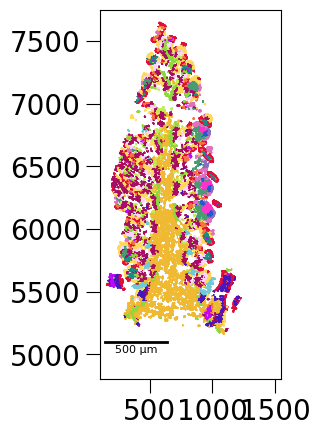

In [40]:
# Ensure the original geometries are preserved
if 'Original_Geometry' not in filtered_segmentation_df.columns:
    filtered_segmentation_df['Original_Geometry'] = filtered_segmentation_df['Geometry']

# Define rotation angle in degrees
rotation_angle = -17
angle_rad = np.radians(rotation_angle)

# Calculate the rotation matrix components
cos_theta = np.cos(angle_rad)
sin_theta = np.sin(angle_rad)

# Get the centroid of the entire sample as the rotation origin
centroid_x = (min_x + max_x) / 2  # Use the previously computed min_x, max_x
centroid_y = (min_y + max_y) / 2  # Use the previously computed min_y, max_y

# Rotation matrix for Shapely's affine_transform (a, b, d, e, xoff, yoff)
rotation_matrix = [
    cos_theta, -sin_theta,  # a, b
    sin_theta, cos_theta,   # d, e
    centroid_x - cos_theta * centroid_x + sin_theta * centroid_y,  # xoff
    centroid_y - sin_theta * centroid_x - cos_theta * centroid_y   # yoff
]

# Rotate the original geometries
rotated_geometries = filtered_segmentation_df['Original_Geometry'].apply(lambda geom: affine_transform(geom, rotation_matrix))

# Update the dataframe with the rotated geometries
filtered_segmentation_df['Geometry'] = rotated_geometries

# Plot the rotated sample
fig, ax = plt.subplots()
patches_list = []

for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    cluster = str(row['clusters'])  # Convert cluster to string to match custom colors dict keys
    
    # Assign color based on the custom mapping, with a default fallback
    color = custom_cluster_colors.get(cluster, default_color)

    if isinstance(shape, MultiPolygon):
        for poly in shape.geoms:
            patch = patches.Polygon(list(poly.exterior.coords), closed=True, facecolor=color, edgecolor='white', linewidth=0.0)
            patches_list.append(patch)
    elif isinstance(shape, Polygon):
        patch = patches.Polygon(list(shape.exterior.coords), closed=True, facecolor=color, edgecolor='white', linewidth=0.0)
        patches_list.append(patch)

# Adjust axis limits as needed
ax.set_xlim([100, 1550])
ax.set_ylim([4800, 7750])
ax.set_aspect('equal')

# Use PatchCollection to handle all patches
collection = PatchCollection(patches_list, match_original=True)
ax.add_collection(collection)

# Add the scale bar
scale_bar_length_microns = 500  # Length of scale bar in microns
scale_bar_x_start = 140        # X-coordinate for the start of the scale bar
scale_bar_y_start = 5100       # Y-coordinate for the start of the scale bar
scale_bar_length_units = scale_bar_length_microns  # Assuming 1 unit = 1 micron

# Add scale bar as a line
scale_bar = Line2D(
    [scale_bar_x_start, scale_bar_x_start + scale_bar_length_units],
    [scale_bar_y_start, scale_bar_y_start],
    color="black",
    linewidth=2
)
ax.add_line(scale_bar)

# Add label for scale bar
ax.text(
    scale_bar_x_start + scale_bar_length_units / 2,
    scale_bar_y_start - 20,  # Adjust to place label below the bar
    f"{scale_bar_length_microns} µm",
    color="black",
    ha="center",
    va="top",
    fontsize=8
)

plt.savefig('leidenclustering/VGN1a6_domainmap_500scalebar.png', dpi=700, bbox_inches='tight', format='png', transparent=False)
plt.show()


### mapping terminal spikelet Mut

In [41]:
# Filter to create a new AnnData object with only the sample 'VGN1a4'
adata_VGN1a4 = adata_spatial[adata_spatial.obs['dataset'] == 'VGN1a4'].copy()

adata_VGN1a4.obs.index = [index.split('-')[0] for index in adata_VGN1a4.obs.index]

# Convert adata_VGN1e1.obs to a dataframe and reset the index to make the index a column
adata_VGN1a4_df = adata_VGN1a4.obs.reset_index()

# Rename the index column if necessary (for example, to 'cell_id')
adata_VGN1a4_df = adata_VGN1a4_df.rename(columns={'index': 'cell_id'})


# Load segmentation data
segmentation_df = gpd.read_parquet("cell_segmentation/VGN1a_region4_output/cellpose2_micron_space_VGN1a4.parquet")

#filter segmentation data to only include high quality, analysed cells
#list the cell ids we want to include
adata_VGN1a4_df['cell_id'] = adata_VGN1a4_df['cell_id'].astype(str).str.strip()
cell_ids = adata_VGN1a4_df['cell_id'].tolist()
cell_ids = [cell_id.strip() for cell_id in cell_ids]

# Convert EntityID in filtered_segmentation_df to strings to match with cell_ids
filtered_segmentation_df = segmentation_df.copy()
filtered_segmentation_df['EntityID'] = filtered_segmentation_df['EntityID'].astype(str)

# Now filter based on matching values in cell_ids
filtered_segmentation_df = filtered_segmentation_df[filtered_segmentation_df['EntityID'].isin(cell_ids)]

#include cluster infomration into the dataframe
adata_VGN1a4_df = adata_VGN1a4.obs[['clusters']].copy()
adata_VGN1a4_df.index = adata_VGN1a4_df.index.astype(str)  # Ensure the index is a string if necessary
filtered_segmentation_df['EntityID'] = filtered_segmentation_df['EntityID'].astype(str)
filtered_segmentation_df = filtered_segmentation_df.merge(adata_VGN1a4_df, left_on='EntityID', right_index=True)
filtered_segmentation_df

ID             EntityID  ZIndex  \
12211  12211  2655350200002100079       6   
11707  11707  2655350200002100079       5   
10951  10951  2655350200002100079       2   
10699  10699  2655350200002100079       3   
11203  11203  2655350200002100079       4   
...      ...                  ...     ...   
10456  10456  2655350200055100164       1   
10393  10393  2655350200055100164       4   
10267  10267  2655350200055100164       3   
10645  10645  2655350200055100164       6   
10519  10519  2655350200055100164       5   

                                                Geometry ParentType ParentID  \
12211  MULTIPOLYGON (((3014.803 5892.732, 3014.595 59...       None     None   
11707  MULTIPOLYGON (((3014.803 5892.732, 3014.595 59...       None     None   
10951  MULTIPOLYGON (((3014.803 5892.732, 3014.595 59...       None     None   
10699  MULTIPOLYGON (((3014.803 5892.732, 3014.595 59...       None     None   
11203  MULTIPOLYGON (((3014.803 5892.732, 3014.595 59...       None     None   
...                                                  ...        ...      ...   
10456  MULTIPOLYGON (((2682.259 8226.024, 2682.387 82...       None     None   
10393  MULTIPOLYGON (((2682.259 8226.024, 2682.387 82...       None     None   
10267  MULTIPOLYGON (((2682.259 8226.024, 2682.387 82...       None     None   
10645  MULTIPOLYGON (((2682.259 8226.024, 2682.387 82...       None     None   
10519  MULTIPOLYGON (((2682.259 8226.024, 2682.387 82...       None     None   

       Type  ZLevel  Name clusters  
12211  cell    10.5  None        9  
11707  cell     9.0  None        9  
10951  cell     4.5  None        9  
10699  cell     6.0  None        9  
11203  cell     7.5  None        9  
...     ...     ...   ...      ...  
10456  cell     3.0  None       16  
10393  cell     7.5  None       16  
10267  cell     6.0  None       16  
10645  cell    10.5  None       16  
10519  cell     9.0  None       16  

[44695 rows x 10 columns]

In [42]:
# I need to look into the region min and max values so I know where to set the axes of graph

# Variables to track min and max x, y
min_x, min_y = float('inf'), float('inf')
max_x, max_y = float('-inf'), float('-inf')

# Iterate through the geometries
for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    
    if isinstance(shape, (Polygon, MultiPolygon)):
        # Get the bounding box of the shape
        bounds = shape.bounds  # Returns (min_x, min_y, max_x, max_y)
        min_x = min(min_x, bounds[0])
        min_y = min(min_y, bounds[1])
        max_x = max(max_x, bounds[2])
        max_y = max(max_y, bounds[3])

# Round to the nearest 1's place
min_x, min_y, max_x, max_y = round(min_x), round(min_y), round(max_x), round(max_y)

# Print the rounded min and max values for x and y
print(f"Min X: {min_x}, Max X: {max_x}")
print(f"Min Y: {min_y}, Max Y: {max_y}")


Min X: 2401, Max X: 3781
Min Y: 5887, Max Y: 8298


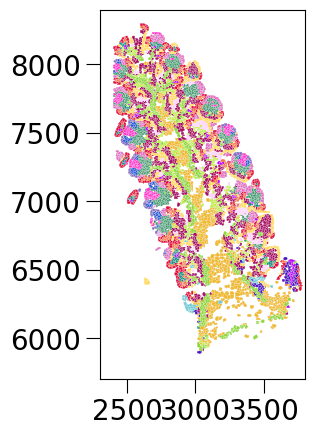

In [43]:
fig, ax = plt.subplots()
patches_list = []

for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    cluster = str(row['clusters'])  # Convert cluster to string to match custom colors dict keys
    
    # Assign color based on the custom mapping, with a default fallback
    color = custom_cluster_colors.get(cluster, default_color)

    if isinstance(shape, MultiPolygon):
        for poly in shape.geoms:
            patch = patches.Polygon(list(poly.exterior.coords), closed=True, facecolor=color, edgecolor='white', linewidth=0.1)
            patches_list.append(patch)
    elif isinstance(shape, Polygon):
        patch = patches.Polygon(list(shape.exterior.coords), closed=True, facecolor=color, edgecolor='white', linewidth=0.1)
        patches_list.append(patch)


# Set axis limits
ax.set_xlim([2300, 3800])
ax.set_ylim([5700, 8400])
ax.set_aspect('equal')

# Use PatchCollection to handle all patches
collection = PatchCollection(patches_list, match_original=True)
ax.add_collection(collection)

plt.show()

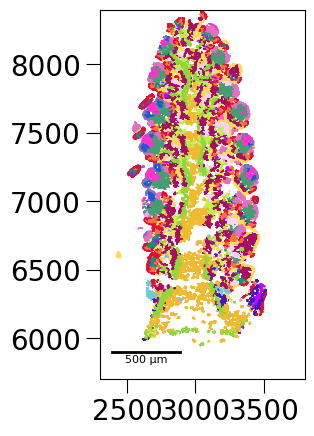

In [44]:
# Ensure the original geometries are preserved
if 'Original_Geometry' not in filtered_segmentation_df.columns:
    filtered_segmentation_df['Original_Geometry'] = filtered_segmentation_df['Geometry']

# Define rotation angle in degrees
rotation_angle = -20
angle_rad = np.radians(rotation_angle)

# Calculate the rotation matrix components
cos_theta = np.cos(angle_rad)
sin_theta = np.sin(angle_rad)

# Get the centroid of the entire sample as the rotation origin
centroid_x = (min_x + max_x) / 2  # Use the previously computed min_x, max_x
centroid_y = (min_y + max_y) / 2  # Use the previously computed min_y, max_y

# Rotation matrix for Shapely's affine_transform (a, b, d, e, xoff, yoff)
rotation_matrix = [
    cos_theta, -sin_theta,  # a, b
    sin_theta, cos_theta,   # d, e
    centroid_x - cos_theta * centroid_x + sin_theta * centroid_y,  # xoff
    centroid_y - sin_theta * centroid_x - cos_theta * centroid_y   # yoff
]

# Rotate the original geometries
rotated_geometries = filtered_segmentation_df['Original_Geometry'].apply(lambda geom: affine_transform(geom, rotation_matrix))

# Update the dataframe with the rotated geometries
filtered_segmentation_df['Geometry'] = rotated_geometries

# Plot the rotated sample
fig, ax = plt.subplots()
patches_list = []

for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    cluster = str(row['clusters'])  # Convert cluster to string to match custom colors dict keys
    
    # Assign color based on the custom mapping, with a default fallback
    color = custom_cluster_colors.get(cluster, default_color)

    if isinstance(shape, MultiPolygon):
        for poly in shape.geoms:
            patch = patches.Polygon(list(poly.exterior.coords), closed=True, facecolor=color, edgecolor='white', linewidth=0.0)
            patches_list.append(patch)
    elif isinstance(shape, Polygon):
        patch = patches.Polygon(list(shape.exterior.coords), closed=True, facecolor=color, edgecolor='white', linewidth=0.0)
        patches_list.append(patch)

# Adjust axis limits as needed
ax.set_xlim([2300, 3800])
ax.set_ylim([5700, 8400])
ax.set_aspect('equal')

# Use PatchCollection to handle all patches
collection = PatchCollection(patches_list, match_original=True)
ax.add_collection(collection)

# Add the scale bar
scale_bar_length_microns = 500  # Length of scale bar in microns
scale_bar_x_start = 2390        # X-coordinate for the start of the scale bar
scale_bar_y_start = 5900       # Y-coordinate for the start of the scale bar
scale_bar_length_units = scale_bar_length_microns  # Assuming 1 unit = 1 micron

# Add scale bar as a line
scale_bar = Line2D(
    [scale_bar_x_start, scale_bar_x_start + scale_bar_length_units],
    [scale_bar_y_start, scale_bar_y_start],
    color="black",
    linewidth=2
)
ax.add_line(scale_bar)

# Add label for scale bar
ax.text(
    scale_bar_x_start + scale_bar_length_units / 2,
    scale_bar_y_start - 20,  # Adjust to place label below the bar
    f"{scale_bar_length_microns} µm",
    color="black",
    ha="center",
    va="top",
    fontsize=8
)

plt.savefig('leidenclustering/VGN1a4_domainmap_500scalebar.png', dpi=1000, bbox_inches='tight', format='png', transparent=False)
plt.show()


## Carpel extension round WT

In [45]:
# Filter to create a new AnnData object with only the sample 'VGN1c2'
adata_VGN1c2 = adata_spatial[adata_spatial.obs['dataset'] == 'VGN1c2'].copy()

adata_VGN1c2.obs.index = [index.split('-')[0] for index in adata_VGN1c2.obs.index]

# Convert adata_VGN1e1.obs to a dataframe and reset the index to make the index a column
adata_VGN1c2_df = adata_VGN1c2.obs.reset_index()

# Rename the index column if necessary (for example, to 'cell_id')
adata_VGN1c2_df = adata_VGN1c2_df.rename(columns={'index': 'cell_id'})


# Load segmentation data
segmentation_df = gpd.read_parquet("cell_segmentation/VGN1c_region2_output/cellpose2_micron_space_VGN1c2.parquet")

#filter segmentation data to only include high quality, analysed cells
#list the cell ids we want to include
adata_VGN1c2_df['cell_id'] = adata_VGN1c2_df['cell_id'].astype(str).str.strip()
cell_ids = adata_VGN1c2_df['cell_id'].tolist()
cell_ids = [cell_id.strip() for cell_id in cell_ids]

# Convert EntityID in filtered_segmentation_df to strings to match with cell_ids
filtered_segmentation_df = segmentation_df.copy()
filtered_segmentation_df['EntityID'] = filtered_segmentation_df['EntityID'].astype(str)

# Now filter based on matching values in cell_ids
filtered_segmentation_df = filtered_segmentation_df[filtered_segmentation_df['EntityID'].isin(cell_ids)]

#include cluster infomration into the dataframe
adata_VGN1c2_df = adata_VGN1c2.obs[['clusters']].copy()
adata_VGN1c2_df.index = adata_VGN1c2_df.index.astype(str)  # Ensure the index is a string if necessary
filtered_segmentation_df['EntityID'] = filtered_segmentation_df['EntityID'].astype(str)
filtered_segmentation_df = filtered_segmentation_df.merge(adata_VGN1c2_df, left_on='EntityID', right_index=True)
filtered_segmentation_df

ID             EntityID  ZIndex  \
26701    26701  2293599400000100091       0   
26885    26885  2293599400000100091       6   
26517    26517  2293599400000100091       5   
25965    25965  2293599400000100091       2   
26333    26333  2293599400000100091       1   
...        ...                  ...     ...   
222308  222308  2293599400212100353       4   
222102  222102  2293599400212100353       2   
222720  222720  2293599400212100353       5   
221896  221896  2293599400212100353       3   
222926  222926  2293599400212100353       0   

                                                 Geometry ParentType ParentID  \
26701   MULTIPOLYGON (((2147.053 2954.890, 2148.056 29...       None     None   
26885   MULTIPOLYGON (((2147.053 2954.890, 2148.056 29...       None     None   
26517   MULTIPOLYGON (((2147.053 2954.890, 2148.056 29...       None     None   
25965   MULTIPOLYGON (((2147.053 2954.890, 2148.056 29...       None     None   
26333   MULTIPOLYGON (((2147.053 2954.890, 2148.056 29...       None     None   
...                                                   ...        ...      ...   
222308  MULTIPOLYGON (((5975.232 6093.677, 5975.280 60...       None     None   
222102  MULTIPOLYGON (((5975.232 6093.677, 5975.280 60...       None     None   
222720  MULTIPOLYGON (((5975.232 6093.677, 5975.280 60...       None     None   
221896  MULTIPOLYGON (((5975.232 6093.677, 5975.280 60...       None     None   
222926  MULTIPOLYGON (((5975.232 6093.677, 5975.280 60...       None     None   

        Type  ZLevel  Name clusters  
26701   cell     1.5  None       14  
26885   cell    10.5  None       14  
26517   cell     9.0  None       14  
25965   cell     4.5  None       14  
26333   cell     3.0  None       14  
...      ...     ...   ...      ...  
222308  cell     7.5  None        4  
222102  cell     4.5  None        4  
222720  cell     9.0  None        4  
221896  cell     6.0  None        4  
222926  cell     1.5  None        4  

[106295 rows x 10 columns]

In [46]:
# I need to look into the region min and max values so I know where to set the axes of graph

# Variables to track min and max x, y
min_x, min_y = float('inf'), float('inf')
max_x, max_y = float('-inf'), float('-inf')

# Iterate through the geometries
for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    
    if isinstance(shape, (Polygon, MultiPolygon)):
        # Get the bounding box of the shape
        bounds = shape.bounds  # Returns (min_x, min_y, max_x, max_y)
        min_x = min(min_x, bounds[0])
        min_y = min(min_y, bounds[1])
        max_x = max(max_x, bounds[2])
        max_y = max(max_y, bounds[3])

# Round to the nearest 1's place
min_x, min_y, max_x, max_y = round(min_x), round(min_y), round(max_x), round(max_y)

# Print the rounded min and max values for x and y
print(f"Min X: {min_x}, Max X: {max_x}")
print(f"Min Y: {min_y}, Max Y: {max_y}")


Min X: 2060, Max X: 6522
Min Y: 2921, Max Y: 6114


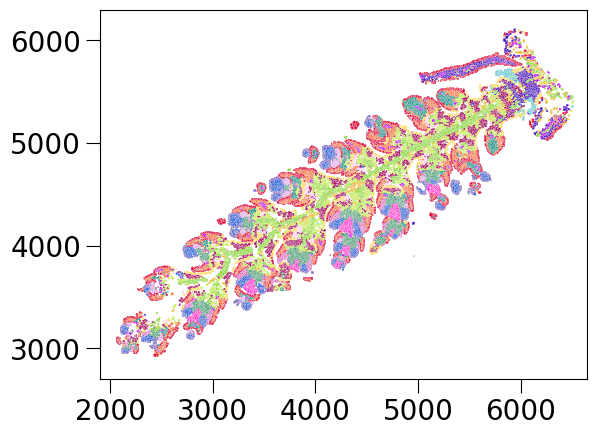

In [47]:
fig, ax = plt.subplots()
patches_list = []

for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    cluster = str(row['clusters'])  # Convert cluster to string to match custom colors dict keys
    
    # Assign color based on the custom mapping, with a default fallback
    color = custom_cluster_colors.get(cluster, default_color)

    if isinstance(shape, MultiPolygon):
        for poly in shape.geoms:
            patch = patches.Polygon(list(poly.exterior.coords), closed=True, facecolor=color, edgecolor='white', linewidth=0.1)
            patches_list.append(patch)
    elif isinstance(shape, Polygon):
        patch = patches.Polygon(list(shape.exterior.coords), closed=True, facecolor=color, edgecolor='white', linewidth=0.1)
        patches_list.append(patch)


# Set axis limits
ax.set_xlim([1900, 6650])
ax.set_ylim([2700, 6300])
ax.set_aspect('equal')

# Use PatchCollection to handle all patches
collection = PatchCollection(patches_list, match_original=True)
ax.add_collection(collection)

plt.show()

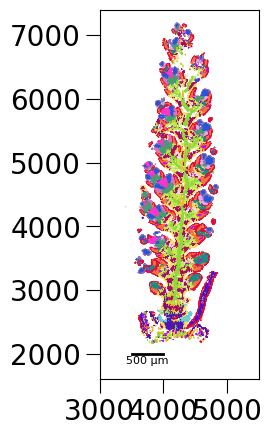

In [48]:
# Ensure the original geometries are preserved
if 'Original_Geometry' not in filtered_segmentation_df.columns:
    filtered_segmentation_df['Original_Geometry'] = filtered_segmentation_df['Geometry']

# Define rotation angle in degrees
rotation_angle = -124
angle_rad = np.radians(rotation_angle)

# Calculate the rotation matrix components
cos_theta = np.cos(angle_rad)
sin_theta = np.sin(angle_rad)

# Get the centroid of the entire sample as the rotation origin
centroid_x = (min_x + max_x) / 2  # Use the previously computed min_x, max_x
centroid_y = (min_y + max_y) / 2  # Use the previously computed min_y, max_y

# Rotation matrix for Shapely's affine_transform (a, b, d, e, xoff, yoff)
rotation_matrix = [
    cos_theta, -sin_theta,  # a, b
    sin_theta, cos_theta,   # d, e
    centroid_x - cos_theta * centroid_x + sin_theta * centroid_y,  # xoff
    centroid_y - sin_theta * centroid_x - cos_theta * centroid_y   # yoff
]

# Rotate the original geometries
rotated_geometries = filtered_segmentation_df['Original_Geometry'].apply(lambda geom: affine_transform(geom, rotation_matrix))

# Update the dataframe with the rotated geometries
filtered_segmentation_df['Geometry'] = rotated_geometries

# Plot the rotated sample
fig, ax = plt.subplots()
patches_list = []

for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    cluster = str(row['clusters'])  # Convert cluster to string to match custom colors dict keys
    
    # Assign color based on the custom mapping, with a default fallback
    color = custom_cluster_colors.get(cluster, default_color)

    if isinstance(shape, MultiPolygon):
        for poly in shape.geoms:
            patch = patches.Polygon(list(poly.exterior.coords), closed=True, facecolor=color, edgecolor='white', linewidth=0.0)
            patches_list.append(patch)
    elif isinstance(shape, Polygon):
        patch = patches.Polygon(list(shape.exterior.coords), closed=True, facecolor=color, edgecolor='white', linewidth=0.0)
        patches_list.append(patch)

# Adjust axis limits as needed
ax.set_xlim([3000, 5500])
ax.set_ylim([1600, 7400])
ax.set_aspect('equal')

# Use PatchCollection to handle all patches
collection = PatchCollection(patches_list, match_original=True)
ax.add_collection(collection)

# Add the scale bar
scale_bar_length_microns = 500  # Length of scale bar in microns
scale_bar_x_start = 3500        # X-coordinate for the start of the scale bar
scale_bar_y_start = 2000       # Y-coordinate for the start of the scale bar
scale_bar_length_units = scale_bar_length_microns  # Assuming 1 unit = 1 micron

# Add scale bar as a line
scale_bar = Line2D(
    [scale_bar_x_start, scale_bar_x_start + scale_bar_length_units],
    [scale_bar_y_start, scale_bar_y_start],
    color="black",
    linewidth=2
)
ax.add_line(scale_bar)

# Add label for scale bar
ax.text(
    scale_bar_x_start + scale_bar_length_units / 2,
    scale_bar_y_start - 30,  # Adjust to place label below the bar
    f"{scale_bar_length_microns} µm",
    color="black",
    ha="center",
    va="top",
    fontsize=8
)

plt.savefig('leidenclustering/VGN1c2_domainmap_500scalebar.png', dpi=1000, bbox_inches='tight', format='png', transparent=False)
plt.show()


making domain map of floral tissues for figure 2 

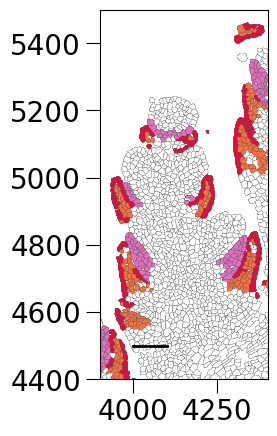

In [49]:
custom_cluster_colors2 = {
    '1': '#e10e3c',
    '2': '#f47140',
    '15': '#e170c0'
}

default_colour = 'whitesmoke'

# Ensure the original geometries are preserved
if 'Original_Geometry' not in filtered_segmentation_df.columns:
    filtered_segmentation_df['Original_Geometry'] = filtered_segmentation_df['Geometry']

# Define rotation angle in degrees
rotation_angle = -160
angle_rad = np.radians(rotation_angle)

# Calculate the rotation matrix components
cos_theta = np.cos(angle_rad)
sin_theta = np.sin(angle_rad)

# Get the centroid of the entire sample as the rotation origin
centroid_x = (min_x + max_x) / 2  # Use the previously computed min_x, max_x
centroid_y = (min_y + max_y) / 2  # Use the previously computed min_y, max_y

# Rotation matrix for Shapely's affine_transform (a, b, d, e, xoff, yoff)
rotation_matrix = [
    cos_theta, -sin_theta,  # a, b
    sin_theta, cos_theta,   # d, e
    centroid_x - cos_theta * centroid_x + sin_theta * centroid_y,  # xoff
    centroid_y - sin_theta * centroid_x - cos_theta * centroid_y   # yoff
]

# Rotate the original geometries
rotated_geometries = filtered_segmentation_df['Original_Geometry'].apply(lambda geom: affine_transform(geom, rotation_matrix))

# Update the dataframe with the rotated geometries
filtered_segmentation_df['Geometry'] = rotated_geometries

# Plot the rotated sample
fig, ax = plt.subplots()
patches_list = []

for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    cluster = str(row['clusters'])  # Convert cluster to string to match custom colors dict keys
    
    # Assign color based on the custom mapping, with a default fallback
    color = custom_cluster_colors2.get(cluster, default_color)

    if isinstance(shape, MultiPolygon):
        for poly in shape.geoms:
            patch = patches.Polygon(list(poly.exterior.coords), closed=True, facecolor=color, edgecolor='#595959', linewidth=0.15)
            patches_list.append(patch)
    elif isinstance(shape, Polygon):
        patch = patches.Polygon(list(shape.exterior.coords), closed=True, facecolor=color, edgecolor='#595959', linewidth=0.15)
        patches_list.append(patch)

# Adjust axis limits as needed
ax.set_xlim([3900, 4400])
ax.set_ylim([4400, 5500])
ax.set_aspect('equal')

# Use PatchCollection to handle all patches
collection = PatchCollection(patches_list, match_original=True)
ax.add_collection(collection)

# Add the scale bar
scale_bar_length_microns = 100 # Length of scale bar in microns
scale_bar_x_start = 4000        # X-coordinate for the start of the scale bar
scale_bar_y_start = 4500       # Y-coordinate for the start of the scale bar
scale_bar_length_units = scale_bar_length_microns  # Assuming 1 unit = 1 micron

# Add scale bar as a line
scale_bar = Line2D(
    [scale_bar_x_start, scale_bar_x_start + scale_bar_length_units],
    [scale_bar_y_start, scale_bar_y_start],
    color="black",
    linewidth=2
)
ax.add_line(scale_bar)


plt.savefig('leidenclustering/VGN1c2_domainmap_floraltissues_100scalebar.png', dpi=700, bbox_inches='tight', format='png', transparent=False)
plt.show()


now I am making a heatmap of gene expression, used for figure 1 

In [50]:
combined_cells_summary_matrix = pd.read_csv('qc/cellmetadata_genecounts_transcriptcounts.csv')
filtered_segmentation_df2 = filtered_segmentation_df.copy()

combined_cells_summary_matrix['EntityID'] = combined_cells_summary_matrix['EntityID'].astype(str)
filtered_segmentation_df2['EntityID'] = filtered_segmentation_df2['EntityID'].astype(str)

# Merge dataframes on 'EntityID', keeping only the necessary column
filtered_segmentation_df2 = filtered_segmentation_df2.merge(
    combined_cells_summary_matrix[['EntityID', 'TraesCS6A02G259000']],
    on='EntityID',
    how='left'
)

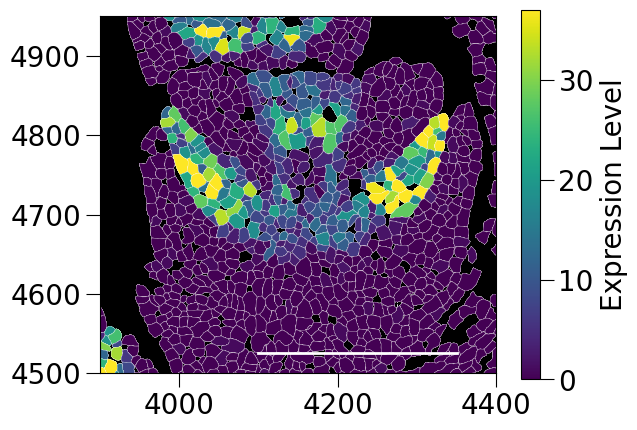

In [57]:

# Rotation logic
if 'Original_Geometry' not in filtered_segmentation_df2.columns:
    filtered_segmentation_df2['Original_Geometry'] = filtered_segmentation_df2['Geometry']

# Define rotation angle in degrees
rotation_angle = -160
angle_rad = np.radians(rotation_angle)

# Calculate the rotation matrix components
cos_theta = np.cos(angle_rad)
sin_theta = np.sin(angle_rad)

# Get the centroid of the entire sample as the rotation origin
centroid_x = (min_x + max_x) / 2  # Use the previously computed min_x, max_x
centroid_y = (min_y + max_y) / 2  # Use the previously computed min_y, max_y

# Rotation matrix for Shapely's affine_transform (a, b, d, e, xoff, yoff)
rotation_matrix = [
    cos_theta, -sin_theta,  # a, b
    sin_theta, cos_theta,   # d, e
    centroid_x - cos_theta * centroid_x + sin_theta * centroid_y,  # xoff
    centroid_y - sin_theta * centroid_x - cos_theta * centroid_y   # yoff
]

# Rotate the original geometries
rotated_geometries = filtered_segmentation_df2['Original_Geometry'].apply(
    lambda geom: affine_transform(geom, rotation_matrix)
)
filtered_segmentation_df2['Geometry'] = rotated_geometries

# Initialize colormap
colormap = cm.get_cmap('viridis')  # You can use other colormaps like 'plasma' or 'cividis'
norm = colors.Normalize(vmin=0, vmax=37)

# Plot the heatmap
fig, ax = plt.subplots()
patches_list = []

for _, row in filtered_segmentation_df2.iterrows():
    shape = row['Geometry']
    normalized_value = row['TraesCS6A02G259000']
    color = colormap(norm(normalized_value))

    if isinstance(shape, MultiPolygon):
        for poly in shape.geoms:
            patch = patches.Polygon(
                list(poly.exterior.coords), closed=True, facecolor=color, edgecolor='white', linewidth=0.15
            )
            patches_list.append(patch)
    elif isinstance(shape, Polygon):
        patch = patches.Polygon(
            list(shape.exterior.coords), closed=True, facecolor=color, edgecolor='white', linewidth=0.15
        )
        patches_list.append(patch)

# Adjust axis limits if needed
ax.set_xlim([3900, 4400])
ax.set_ylim([4500, 4950])
ax.set_aspect('equal')

# Use PatchCollection to handle all patches
collection = PatchCollection(patches_list, match_original=True)
ax.add_collection(collection)

# Add the scale bar
scale_bar_length_microns = 250 # Length of scale bar in microns
scale_bar_x_start = 4100      # X-coordinate for the start of the scale bar
scale_bar_y_start = 4525       # Y-coordinate for the start of the scale bar
scale_bar_length_units = scale_bar_length_microns  # Assuming 1 unit = 1 micron

scale_bar = Line2D(
    [scale_bar_x_start, scale_bar_x_start + scale_bar_length_microns],
    [scale_bar_y_start, scale_bar_y_start],
    color="white",
    linewidth=2
)
ax.add_line(scale_bar)

# Add colorbar
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=colormap), ax=ax, label="Expression Level")
ax.set_facecolor('black')
plt.savefig('leidenclustering/VGN1c2_heatmapAGL6_floraltissues_100scalebar.png', dpi=700, bbox_inches='tight', format='png')
plt.show()


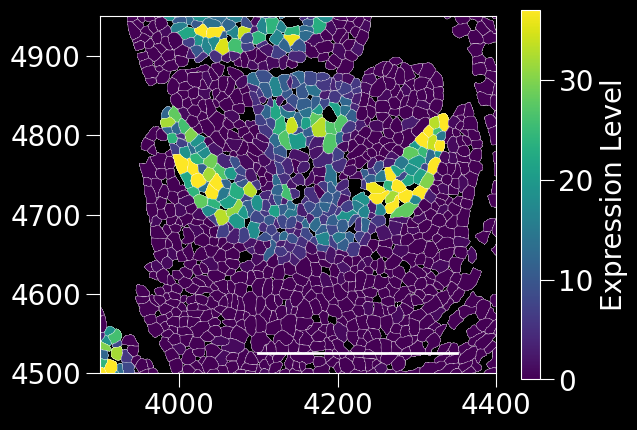

In [58]:
plt.style.use('dark_background')
# Rotation logic
if 'Original_Geometry' not in filtered_segmentation_df2.columns:
    filtered_segmentation_df2['Original_Geometry'] = filtered_segmentation_df2['Geometry']

# Define rotation angle in degrees
rotation_angle = -160
angle_rad = np.radians(rotation_angle)

# Calculate the rotation matrix components
cos_theta = np.cos(angle_rad)
sin_theta = np.sin(angle_rad)

# Get the centroid of the entire sample as the rotation origin
centroid_x = (min_x + max_x) / 2  # Use the previously computed min_x, max_x
centroid_y = (min_y + max_y) / 2  # Use the previously computed min_y, max_y

# Rotation matrix for Shapely's affine_transform (a, b, d, e, xoff, yoff)
rotation_matrix = [
    cos_theta, -sin_theta,  # a, b
    sin_theta, cos_theta,   # d, e
    centroid_x - cos_theta * centroid_x + sin_theta * centroid_y,  # xoff
    centroid_y - sin_theta * centroid_x - cos_theta * centroid_y   # yoff
]

# Rotate the original geometries
rotated_geometries = filtered_segmentation_df2['Original_Geometry'].apply(
    lambda geom: affine_transform(geom, rotation_matrix)
)
filtered_segmentation_df2['Geometry'] = rotated_geometries

# Initialize colormap
colormap = cm.get_cmap('viridis')  # You can use other colormaps like 'plasma' or 'cividis'
norm = colors.Normalize(vmin=0, vmax=37)

# Plot the heatmap
fig, ax = plt.subplots()
patches_list = []

for _, row in filtered_segmentation_df2.iterrows():
    shape = row['Geometry']
    normalized_value = row['TraesCS6A02G259000']
    color = colormap(norm(normalized_value))

    if isinstance(shape, MultiPolygon):
        for poly in shape.geoms:
            patch = patches.Polygon(
                list(poly.exterior.coords), closed=True, facecolor=color, edgecolor='white', linewidth=0.15
            )
            patches_list.append(patch)
    elif isinstance(shape, Polygon):
        patch = patches.Polygon(
            list(shape.exterior.coords), closed=True, facecolor=color, edgecolor='white', linewidth=0.15
        )
        patches_list.append(patch)

# Adjust axis limits if needed
ax.set_xlim([3900, 4400])
ax.set_ylim([4500, 4950])
ax.set_aspect('equal')

# Use PatchCollection to handle all patches
collection = PatchCollection(patches_list, match_original=True)
ax.add_collection(collection)

# Add the scale bar
scale_bar_length_microns = 250 # Length of scale bar in microns
scale_bar_x_start = 4100      # X-coordinate for the start of the scale bar
scale_bar_y_start = 4525       # Y-coordinate for the start of the scale bar
scale_bar_length_units = scale_bar_length_microns  # Assuming 1 unit = 1 micron

scale_bar = Line2D(
    [scale_bar_x_start, scale_bar_x_start + scale_bar_length_microns],
    [scale_bar_y_start, scale_bar_y_start],
    color="white",
    linewidth=2
)
ax.add_line(scale_bar)

# Add colorbar
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=colormap), ax=ax, label="Expression Level")
ax.set_facecolor('black')
plt.savefig('leidenclustering/VGN1c2_heatmapAGL6_floraltissues_100scalebar_darkbackground.png', dpi=700, bbox_inches='tight', format='png')
plt.show()


## carpel extension round MUT

In [64]:
# Filter to create a new AnnData object with only the sample 'VGN1c3'
adata_VGN1c3 = adata_spatial[adata_spatial.obs['dataset'] == 'VGN1c3'].copy()

adata_VGN1c3.obs.index = [index.split('-')[0] for index in adata_VGN1c3.obs.index]

# Convert adata_VGN1e1.obs to a dataframe and reset the index to make the index a column
adata_VGN1c3_df = adata_VGN1c3.obs.reset_index()

# Rename the index column if necessary (for example, to 'cell_id')
adata_VGN1c3_df = adata_VGN1c3_df.rename(columns={'index': 'cell_id'})


# Load segmentation data
segmentation_df = gpd.read_parquet("cell_segmentation/VGN1c_region3_output/cellpose2_micron_space_VGN1c3.parquet")

#filter segmentation data to only include high quality, analysed cells
#list the cell ids we want to include
adata_VGN1c3_df['cell_id'] = adata_VGN1c3_df['cell_id'].astype(str).str.strip()
cell_ids = adata_VGN1c3_df['cell_id'].tolist()
cell_ids = [cell_id.strip() for cell_id in cell_ids]

# Convert EntityID in filtered_segmentation_df to strings to match with cell_ids
filtered_segmentation_df = segmentation_df.copy()
filtered_segmentation_df['EntityID'] = filtered_segmentation_df['EntityID'].astype(str)

# Now filter based on matching values in cell_ids
filtered_segmentation_df = filtered_segmentation_df[filtered_segmentation_df['EntityID'].isin(cell_ids)]

#include cluster infomration into the dataframe
adata_VGN1c3_df = adata_VGN1c3.obs[['clusters']].copy()
adata_VGN1c3_df.index = adata_VGN1c3_df.index.astype(str)  # Ensure the index is a string if necessary
filtered_segmentation_df['EntityID'] = filtered_segmentation_df['EntityID'].astype(str)
filtered_segmentation_df = filtered_segmentation_df.merge(adata_VGN1c3_df, left_on='EntityID', right_index=True)
filtered_segmentation_df

ID             EntityID  ZIndex  \
30064  30064  2654449700017100069       4   
30397  30397  2654449700017100069       0   
29953  29953  2654449700017100069       2   
30286  30286  2654449700017100069       5   
29842  29842  2654449700017100069       3   
...      ...                  ...     ...   
27037  27037  2654449700218100189       3   
27119  27119  2654449700218100189       2   
27365  27365  2654449700218100189       5   
27201  27201  2654449700218100189       4   
27283  27283  2654449700218100189       1   

                                                Geometry ParentType ParentID  \
30064  MULTIPOLYGON (((1833.951 5009.770, 1834.890 50...       None     None   
30397  MULTIPOLYGON (((1833.951 5009.770, 1834.890 50...       None     None   
29953  MULTIPOLYGON (((1833.951 5009.770, 1834.890 50...       None     None   
30286  MULTIPOLYGON (((1833.951 5009.770, 1834.890 50...       None     None   
29842  MULTIPOLYGON (((1833.951 5009.770, 1834.890 50...       None     None   
...                                                  ...        ...      ...   
27037  MULTIPOLYGON (((5778.878 7867.979, 5780.133 78...       None     None   
27119  MULTIPOLYGON (((5778.878 7867.979, 5780.133 78...       None     None   
27365  MULTIPOLYGON (((5778.878 7867.979, 5780.133 78...       None     None   
27201  MULTIPOLYGON (((5778.878 7867.979, 5780.133 78...       None     None   
27283  MULTIPOLYGON (((5778.878 7867.979, 5780.133 78...       None     None   

       Type  ZLevel  Name clusters  
30064  cell     7.5  None        1  
30397  cell     1.5  None        1  
29953  cell     4.5  None        1  
30286  cell     9.0  None        1  
29842  cell     6.0  None        1  
...     ...     ...   ...      ...  
27037  cell     6.0  None       13  
27119  cell     4.5  None       13  
27365  cell     9.0  None       13  
27201  cell     7.5  None       13  
27283  cell     3.0  None       13  

[104825 rows x 10 columns]

In [65]:
# I need to look into the region min and max values so I know where to set the axes of graph

# Variables to track min and max x, y
min_x, min_y = float('inf'), float('inf')
max_x, max_y = float('-inf'), float('-inf')

# Iterate through the geometries
for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    
    if isinstance(shape, (Polygon, MultiPolygon)):
        # Get the bounding box of the shape
        bounds = shape.bounds  # Returns (min_x, min_y, max_x, max_y)
        min_x = min(min_x, bounds[0])
        min_y = min(min_y, bounds[1])
        max_x = max(max_x, bounds[2])
        max_y = max(max_y, bounds[3])

# Round to the nearest 1's place
min_x, min_y, max_x, max_y = round(min_x), round(min_y), round(max_x), round(max_y)

# Print the rounded min and max values for x and y
print(f"Min X: {min_x}, Max X: {max_x}")
print(f"Min Y: {min_y}, Max Y: {max_y}")


Min X: 1814, Max X: 6184
Min Y: 4929, Max Y: 7967


In [66]:
plt.style.use('default') 

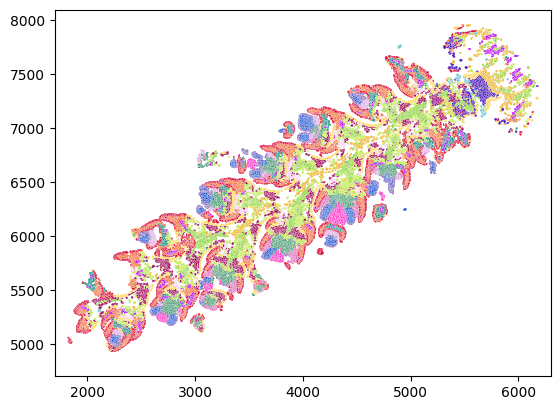

In [67]:
fig, ax = plt.subplots()
patches_list = []

for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    cluster = str(row['clusters'])  # Convert cluster to string to match custom colors dict keys
    
    # Assign color based on the custom mapping, with a default fallback
    color = custom_cluster_colors.get(cluster, default_color)

    if isinstance(shape, MultiPolygon):
        for poly in shape.geoms:
            patch = patches.Polygon(list(poly.exterior.coords), closed=True, facecolor=color, edgecolor='white', linewidth=0.1)
            patches_list.append(patch)
    elif isinstance(shape, Polygon):
        patch = patches.Polygon(list(shape.exterior.coords), closed=True, facecolor=color, edgecolor='white', linewidth=0.1)
        patches_list.append(patch)


# Set axis limits
ax.set_xlim([1700, 6300])
ax.set_ylim([4700, 8100])
ax.set_aspect('equal')

# Use PatchCollection to handle all patches
collection = PatchCollection(patches_list, match_original=True)
ax.add_collection(collection)

plt.show()

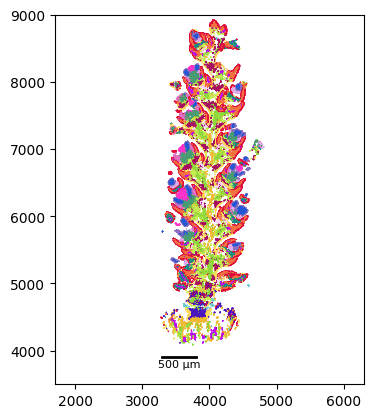

In [68]:
# Ensure the original geometries are preserved
if 'Original_Geometry' not in filtered_segmentation_df.columns:
    filtered_segmentation_df['Original_Geometry'] = filtered_segmentation_df['Geometry']

# Define rotation angle in degrees
rotation_angle = -124
angle_rad = np.radians(rotation_angle)

# Calculate the rotation matrix components
cos_theta = np.cos(angle_rad)
sin_theta = np.sin(angle_rad)

# Get the centroid of the entire sample as the rotation origin
centroid_x = (min_x + max_x) / 2  # Use the previously computed min_x, max_x
centroid_y = (min_y + max_y) / 2  # Use the previously computed min_y, max_y

# Rotation matrix for Shapely's affine_transform (a, b, d, e, xoff, yoff)
rotation_matrix = [
    cos_theta, -sin_theta,  # a, b
    sin_theta, cos_theta,   # d, e
    centroid_x - cos_theta * centroid_x + sin_theta * centroid_y,  # xoff
    centroid_y - sin_theta * centroid_x - cos_theta * centroid_y   # yoff
]

# Rotate the original geometries
rotated_geometries = filtered_segmentation_df['Original_Geometry'].apply(lambda geom: affine_transform(geom, rotation_matrix))

# Update the dataframe with the rotated geometries
filtered_segmentation_df['Geometry'] = rotated_geometries

# Plot the rotated sample
fig, ax = plt.subplots()
patches_list = []

for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    cluster = str(row['clusters'])  # Convert cluster to string to match custom colors dict keys
    
    # Assign color based on the custom mapping, with a default fallback
    color = custom_cluster_colors.get(cluster, default_color)

    if isinstance(shape, MultiPolygon):
        for poly in shape.geoms:
            patch = patches.Polygon(list(poly.exterior.coords), closed=True, facecolor=color, edgecolor='white', linewidth=0.0)
            patches_list.append(patch)
    elif isinstance(shape, Polygon):
        patch = patches.Polygon(list(shape.exterior.coords), closed=True, facecolor=color, edgecolor='white', linewidth=0.0)
        patches_list.append(patch)


# Adjust axis limits as needed
ax.set_xlim([1700, 6300])
ax.set_ylim([3500, 9000])
ax.set_aspect('equal')

# Use PatchCollection to handle all patches
collection = PatchCollection(patches_list, match_original=True)
ax.add_collection(collection)

# Add the scale bar
scale_bar_length_microns = 500  # Length of scale bar in microns
scale_bar_x_start = 3300        # X-coordinate for the start of the scale bar
scale_bar_y_start = 3900       # Y-coordinate for the start of the scale bar
scale_bar_length_units = scale_bar_length_microns  # Assuming 1 unit = 1 micron

# Add scale bar as a line
scale_bar = Line2D(
    [scale_bar_x_start, scale_bar_x_start + scale_bar_length_units],
    [scale_bar_y_start, scale_bar_y_start],
    color="black",
    linewidth=2
)
ax.add_line(scale_bar)

# Add label for scale bar
ax.text(
    scale_bar_x_start + scale_bar_length_units / 2,
    scale_bar_y_start - 30,  # Adjust to place label below the bar
    f"{scale_bar_length_microns} µm",
    color="black",
    ha="center",
    va="top",
    fontsize=8
)

plt.savefig('leidenclustering/VGN1c3_domainmap_500scalebar.png', dpi=1000, bbox_inches='tight', format='png')
plt.show()


# Visualising marker genes with spatial maps, annotated with transcripts

In [69]:
segmentation_df = gpd.read_parquet('cell_segmentation/VGN1e_region1_output/cellpose2_micron_space_VGN1e1.parquet')

transcripts_df = pd.read_csv('cell_segmentation/VGN1e_region1_output/detected_transcripts_VGN1e1.csv') 

In [70]:
# Filter to create a new AnnData object with only the sample 'VGN1e1' with my cluster information included 
adata_VGN1e1 = adata_spatial[adata_spatial.obs['dataset'] == 'VGN1e1'].copy()

adata_VGN1e1.obs.index = [index.split('-')[0] for index in adata_VGN1e1.obs.index]

# Convert adata_VGN1e1.obs to a dataframe and reset the index to make the index a column
adata_VGN1e1_df = adata_VGN1e1.obs.reset_index()

# Extract id for all cells in my VGN1e1 sample 
adata_VGN1e1_df = adata_VGN1e1_df.rename(columns={'index': 'cell_id'})

adata_VGN1e1_df['cell_id'] = adata_VGN1e1_df['cell_id'].astype(str).str.strip()
cell_ids = adata_VGN1e1_df['cell_id'].tolist()
cell_ids = [cell_id.strip() for cell_id in cell_ids]


# Convert EntityID in filtered_segmentation_df to strings to match with cell_ids
filtered_segmentation_df = segmentation_df.copy()
filtered_segmentation_df['EntityID'] = filtered_segmentation_df['EntityID'].astype(str)

# Now filter based on matching values in cell_ids
filtered_segmentation_df = filtered_segmentation_df[filtered_segmentation_df['EntityID'].isin(cell_ids)]

#merge with segmentation information with cluster information 
adata_VGN1e1_df = adata_VGN1e1.obs[['clusters']].copy()
adata_VGN1e1_df.index = adata_VGN1e1_df.index.astype(str)  # Ensure the index is a string if necessary

merged_segmentation_df = filtered_segmentation_df.merge(adata_VGN1e1_df, left_on='EntityID', right_index=True)
merged_segmentation_df

ID             EntityID  ZIndex  \
48334  48334  2343479300017100075       1   
48829  48829  2343479300017100075       6   
48664  48664  2343479300017100075       0   
48499  48499  2343479300017100075       5   
48004  48004  2343479300017100075       2   
...      ...                  ...     ...   
28175  28175  2343479300098100014       2   
28195  28195  2343479300098100014       0   
28200  28200  2343479300098100014       6   
28185  28185  2343479300098100014       1   
28170  28170  2343479300098100014       3   

                                                Geometry ParentType ParentID  \
48334  MULTIPOLYGON (((3408.174 6460.388, 3408.210 64...       None     None   
48829  MULTIPOLYGON (((3408.174 6460.388, 3408.210 64...       None     None   
48664  MULTIPOLYGON (((3408.174 6460.388, 3408.210 64...       None     None   
48499  MULTIPOLYGON (((3408.174 6460.388, 3408.210 64...       None     None   
48004  MULTIPOLYGON (((3408.174 6460.388, 3408.210 64...       None     None   
...                                                  ...        ...      ...   
28175  MULTIPOLYGON (((4221.030 7741.360, 4222.109 77...       None     None   
28195  MULTIPOLYGON (((4221.030 7741.360, 4222.109 77...       None     None   
28200  MULTIPOLYGON (((4221.030 7741.360, 4222.109 77...       None     None   
28185  MULTIPOLYGON (((4221.030 7741.360, 4222.109 77...       None     None   
28170  MULTIPOLYGON (((4221.030 7741.360, 4222.109 77...       None     None   

       Type  ZLevel  Name clusters  
48334  cell     3.0  None        6  
48829  cell    10.5  None        6  
48664  cell     1.5  None        6  
48499  cell     9.0  None        6  
48004  cell     4.5  None        6  
...     ...     ...   ...      ...  
28175  cell     4.5  None       12  
28195  cell     1.5  None       12  
28200  cell    10.5  None       12  
28185  cell     3.0  None       12  
28170  cell     6.0  None       12  

[15463 rows x 10 columns]

In [71]:
#Now I also want to filter out my transcripts, because there are many that aren't relevant to me and this slows down computational time
#I will filter to only transcripts that fall within the cells of interest 

# Ensures that filtered_segmentation_df is a GeoDataFrame with geometries representing spatial areas (e.g., polygons).
filtered_segmentation_df = gpd.GeoDataFrame(filtered_segmentation_df, geometry='Geometry')

# Converts transcripts_df into a GeoDataFrame where each transcript is represented as a point geometry derived from its global_x and global_y coordinates.
transcripts_gdf = gpd.GeoDataFrame(
    transcripts_df,
    geometry=gpd.points_from_xy(transcripts_df['global_x'], transcripts_df['global_y'])
)

# Matches transcript points (transcripts_gdf) to spatial regions (filtered_segmentation_df) using a spatial join (predicate='within').
filtered_transcripts_gdf = gpd.sjoin(
    transcripts_gdf,
    filtered_segmentation_df[['EntityID', 'Geometry']],
    how='inner',
    predicate='within'
)

# Remove unnecessary columns and duplicates
filtered_transcripts_df = (
    filtered_transcripts_gdf
    .drop(columns=['index_right', 'Unnamed: 0'], errors='ignore')  # Drop join-related columns
    .drop_duplicates()  # Remove duplicate rows
)

# Reset the index for clarity
filtered_transcripts_df.reset_index(drop=True, inplace=True)

# Display result
filtered_transcripts_df


barcode_id   global_x   global_y  global_z          x           y  \
0               38  3446.3018  7837.6090       1.0  388.12305   474.39932   
1               40  3444.9426  7839.1235       1.0  375.53894   488.42523   
2               70  3444.9240  7838.3220       1.0  375.36667   481.00000   
3               93  3442.4006  7835.5137       1.0  352.00000   455.00000   
4               98  3444.8670  7839.4214       1.0  374.83790   491.18338   
...            ...        ...        ...       ...        ...         ...   
325696         129  4121.7773  6368.6880       6.0  971.40650  1758.59350   
325697         196  4116.4194  6367.1820       6.0  921.79400  1744.65250   
325698         196  4120.6953  6369.7456       6.0  961.38745  1768.38750   
325699         211  4115.4690  6368.1646       6.0  913.00000  1753.74580   
325700         245  4123.5693  6371.2160       6.0  988.00000  1782.00000   

        fov                gene         transcript_id              cell_id  \
0        75  TraesCS3D02G284200  TraesCS3D02G284200_1  2343479300095100291   
1        75  TraesCS1A02G199600  TraesCS1A02G199600_2  2343479300095100291   
2        75  TraesCS7D02G246100  TraesCS7D02G246100_1  2343479300095100291   
3        75  TraesCS3B02G435700  TraesCS3B02G435700_1  2343479300095100291   
4        75  TraesCS4D02G076900  TraesCS4D02G076900_1  2343479300095100291   
...     ...                 ...                   ...                  ...   
325696  199  TraesCS7A02G313100  TraesCS7A02G313100_3  2343479300019100003   
325697  199  TraesCS2B02G260800  TraesCS2B02G260800_1  2343479300019100003   
325698  199  TraesCS2B02G260800  TraesCS2B02G260800_1  2343479300019100003   
325699  199  TraesCS2A02G114900  TraesCS2A02G114900_1  2343479300019100003   
325700  199  TraesCS2A02G391100  TraesCS2A02G391100_2  2343479300019100003   

                         geometry             EntityID  
0       POINT (3446.302 7837.609)  2343479300095100291  
1       POINT (3444.943 7839.123)  2343479300095100291  
2       POINT (3444.924 7838.322)  2343479300095100291  
3       POINT (3442.401 7835.514)  2343479300095100291  
4       POINT (3444.867 7839.421)  2343479300095100291  
...                           ...                  ...  
325696  POINT (4121.777 6368.688)  2343479300019100003  
325697  POINT (4116.419 6367.182)  2343479300019100003  
325698  POINT (4120.695 6369.746)  2343479300019100003  
325699  POINT (4115.469 6368.165)  2343479300019100003  
325700  POINT (4123.569 6371.216)  2343479300019100003  

[325701 rows x 12 columns]

first I will label the expression domains of interest 

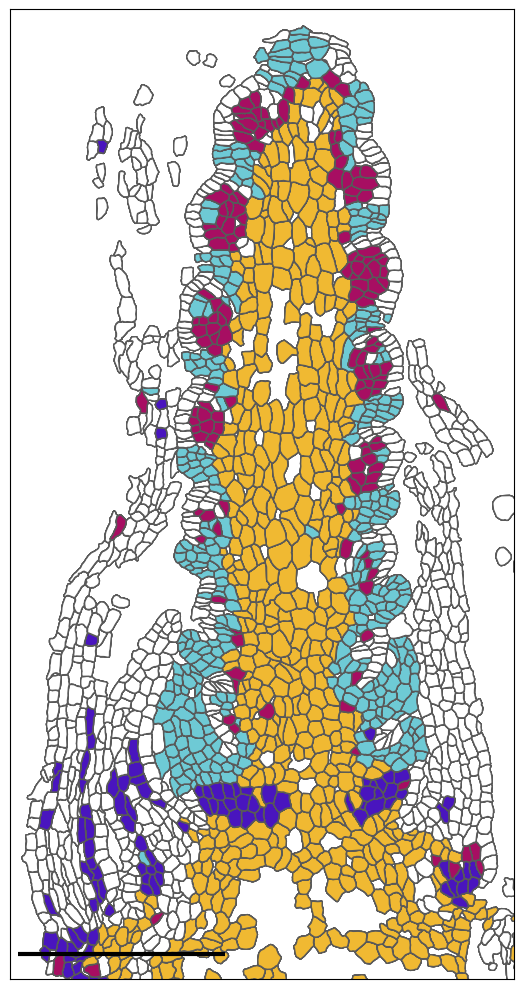

In [79]:
# Define custom colors for specific clusters
custom_cluster_colors = {
    '0': '#a70e62', 
    '12': '#6ecad5',
    '9': '#4915be', 
    '3': '#f0b932'   
}

# Default color for unspecified clusters
default_color = "white"

# Define rotation parameters
angle = -22  # Degrees
radians = math.radians(angle)
cos_angle = math.cos(radians)
sin_angle = math.sin(radians)
rotation_matrix = np.array([[cos_angle, -sin_angle], [sin_angle, cos_angle]])

# Calculate the center of the filtered segmentation data for rotation
segmentation_center_x = merged_segmentation_df['Geometry'].centroid.x.mean()
segmentation_center_y = merged_segmentation_df['Geometry'].centroid.y.mean()

# Apply rotation and assign cluster colors to each Polygon
rotated_patches_list = []
for _, row in merged_segmentation_df.iterrows():
    shape = row['Geometry']
    cluster = str(row['clusters'])  # Convert cluster to string to match custom colors dict keys

    # Assign color based on cluster
    color = custom_cluster_colors.get(cluster, default_color)

    if isinstance(shape, MultiPolygon):
        for poly in shape.geoms:
            centered_coords = np.array(poly.exterior.coords) - np.array([segmentation_center_x, segmentation_center_y])
            rotated_coords = np.dot(centered_coords, rotation_matrix) + np.array([segmentation_center_x, segmentation_center_y])
            rotated_poly = Polygon(rotated_coords)
            patch = patches.Polygon(rotated_coords, closed=True, facecolor=color, edgecolor='#595959', linewidth=1.0)
            rotated_patches_list.append(patch)
    elif isinstance(shape, Polygon):
        centered_coords = np.array(shape.exterior.coords) - np.array([segmentation_center_x, segmentation_center_y])
        rotated_coords = np.dot(centered_coords, rotation_matrix) + np.array([segmentation_center_x, segmentation_center_y])
        rotated_poly = Polygon(rotated_coords)
        patch = patches.Polygon(rotated_coords, closed=True, facecolor=color, edgecolor='#595959', linewidth=1.0)
        rotated_patches_list.append(patch)

# Plot the rotated and colored polygons
fig, ax = plt.subplots(figsize=(10, 10))

# Add rotated polygons
collection = PatchCollection(rotated_patches_list, match_original=True)
ax.add_collection(collection)

# Calculate axis limits
rotated_x_coords = [coord[0] for patch in rotated_patches_list for coord in patch.get_xy()]
rotated_y_coords = [coord[1] for patch in rotated_patches_list for coord in patch.get_xy()]
x_min, x_max = min(rotated_x_coords), max(rotated_x_coords)
y_min, y_max = min(rotated_y_coords), max(rotated_y_coords)

# Set axis limits
ax.set_ylim(6650, 7825)
ax.set_xlim(3610, 4220)
ax.set_aspect('equal')

# Add a 25-micron scale bar
scale_bar_length = 250  # Microns
x_start = 3620  # Starting x-coordinate of the scale bar
y_start = 6680  # Starting y-coordinate of the scale bar
x_end = x_start + scale_bar_length  # Ending x-coordinate of the scale bar

# Draw the scale bar line
ax.hlines(y_start, x_start, x_end, colors='black', linewidth=3)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])


plt.tight_layout()
plt.savefig('enrichmentanalysis/VGN1e1_domainmap_250scalebar.png', dpi=700, bbox_inches='tight', format='png', transparent=True)
plt.show()


now I will plot out enriched gene markers of interest 

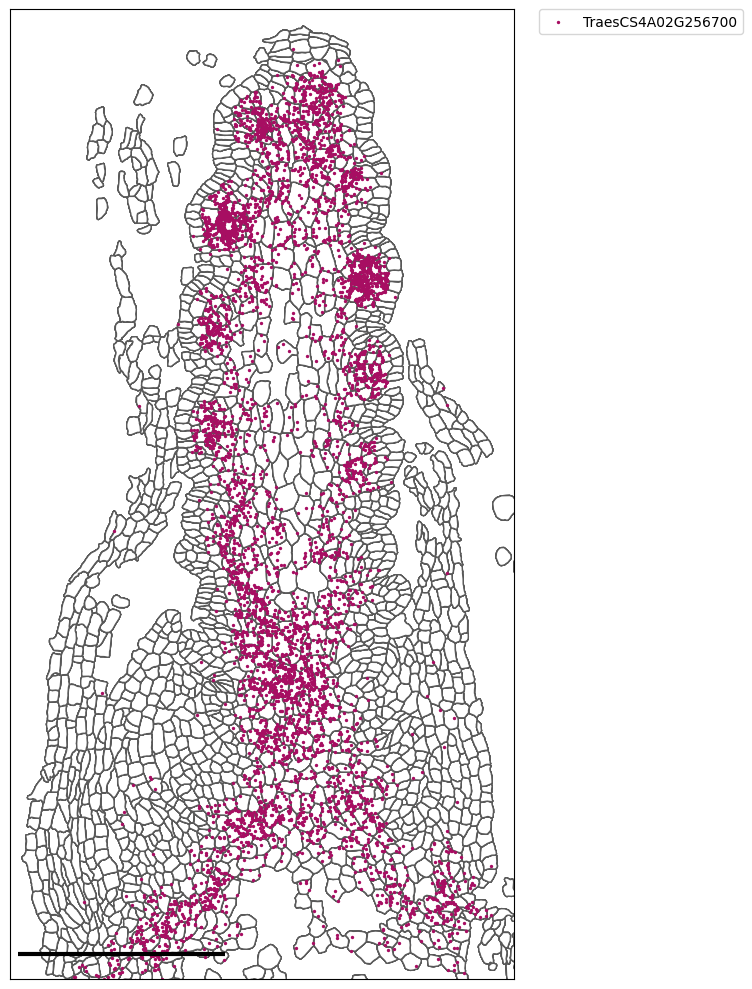

In [80]:
transcripts_in_area = filtered_transcripts_df.copy()

# Define genes and colors
genes_of_interest = {
    'TraesCS4A02G256700': '#a70e62'
}

# Define rotation parameters
angle = -22 # Degrees
radians = math.radians(angle)
cos_angle = math.cos(radians)
sin_angle = math.sin(radians)
rotation_matrix = np.array([[cos_angle, -sin_angle], [sin_angle, cos_angle]])

# Calculate the center of the filtered segmentation data for rotation
segmentation_center_x = filtered_segmentation_df['Geometry'].centroid.x.mean()
segmentation_center_y = filtered_segmentation_df['Geometry'].centroid.y.mean()

# Apply rotation to each Polygon in the filtered segmentation data
rotated_patches_list = []
rotated_polygons = []  # Store rotated polygons for containment checks
rotated_centroids = []  # Store centroids of rotated polygons for bin assignment
for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    if isinstance(shape, MultiPolygon):
        for poly in shape.geoms:
            centered_coords = np.array(poly.exterior.coords) - np.array([segmentation_center_x, segmentation_center_y])
            rotated_coords = np.dot(centered_coords, rotation_matrix) + np.array([segmentation_center_x, segmentation_center_y])
            rotated_poly = Polygon(rotated_coords)
            rotated_polygons.append(rotated_poly)
            rotated_centroids.append(rotated_poly.centroid)
            patch = patches.Polygon(rotated_coords, closed=True, facecolor="white", edgecolor='#595959', linewidth=1)
            rotated_patches_list.append(patch)
    elif isinstance(shape, Polygon):
        centered_coords = np.array(shape.exterior.coords) - np.array([segmentation_center_x, segmentation_center_y])
        rotated_coords = np.dot(centered_coords, rotation_matrix) + np.array([segmentation_center_x, segmentation_center_y])
        rotated_poly = Polygon(rotated_coords)
        rotated_polygons.append(rotated_poly)
        rotated_centroids.append(rotated_poly.centroid)
        patch = patches.Polygon(rotated_coords, closed=True, facecolor="white", edgecolor='#595959', linewidth=1)
        rotated_patches_list.append(patch)

# Apply rotation to transcript coordinates
rotated_transcript_data = {}
for gene, color in genes_of_interest.items():
    transcripts_of_interest = transcripts_in_area[transcripts_in_area['gene'] == gene].copy()
    transcript_coords = transcripts_of_interest[['global_x', 'global_y']].to_numpy()
    centered_transcript_coords = transcript_coords - np.array([segmentation_center_x, segmentation_center_y])
    rotated_transcript_coords = np.dot(centered_transcript_coords, rotation_matrix) + np.array([segmentation_center_x, segmentation_center_y])
    
    # Add rotated transcript coordinates for plotting
    rotated_transcript_data[gene] = {
        'x': rotated_transcript_coords[:, 0],
        'y': rotated_transcript_coords[:, 1],
        'color': color
    }


# Plot the rotated segmentation and transcripts
fig, ax = plt.subplots(figsize=(10, 10))

# Add rotated segmentation polygons
collection = PatchCollection(rotated_patches_list, match_original=True)
ax.add_collection(collection)

# Plot each gene's filtered transcripts with unique colors
for gene, data in rotated_transcript_data.items():
    ax.scatter(data['x'], data['y'], color=data['color'], s=2, alpha=1, label=gene)

# Set axis limits
ax.set_ylim(6650, 7825)
ax.set_xlim(3610, 4220)
ax.set_aspect('equal')

# Place the legend outside the plot
ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0, prop=dict(size=10))

# Add a 25-micron scale bar
scale_bar_length = 250  # Microns
x_start = 3620  # Starting x-coordinate of the scale bar
y_start = 6680  # Starting y-coordinate of the scale bar
x_end = x_start + scale_bar_length  # Ending x-coordinate of the scale bar

# Draw the scale bar line
ax.hlines(y_start, x_start, x_end, colors='black', linewidth=3)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])


plt.tight_layout()
plt.savefig('enrichmentanalysis/VGN1e1_KNOX5map_250scalebar.png', dpi=700, bbox_inches='tight', format='png', transparent=True)
plt.show()


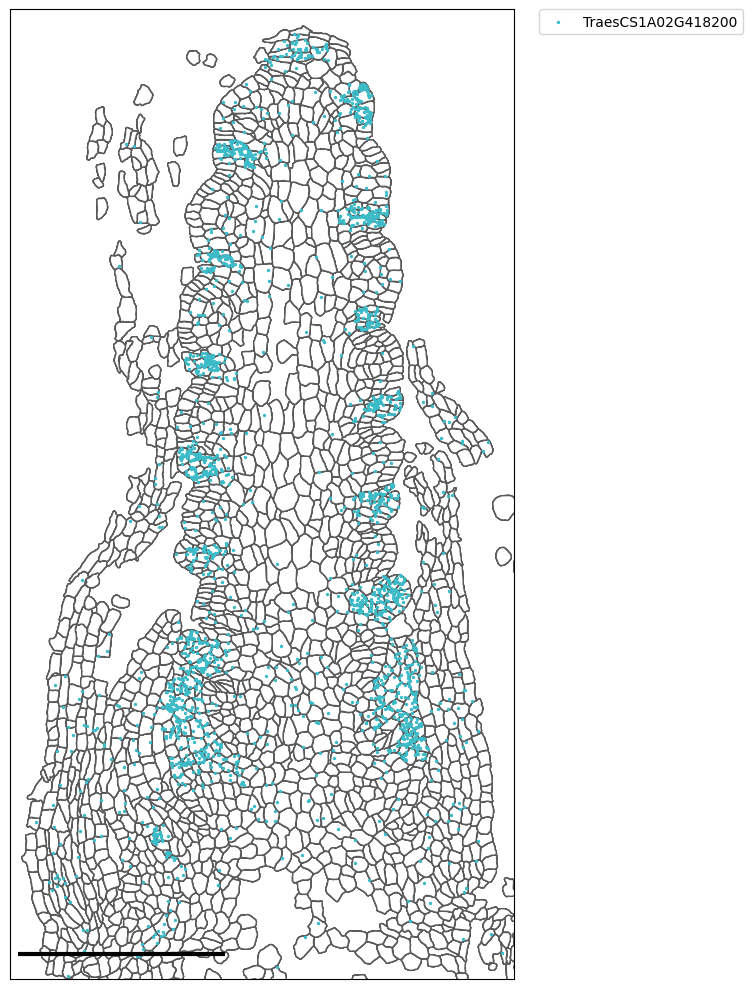

In [85]:
# Define genes and colors
genes_of_interest = {
    'TraesCS1A02G418200': '#3CBBC8'
}

# Define rotation parameters
angle = -22 # Degrees
radians = math.radians(angle)
cos_angle = math.cos(radians)
sin_angle = math.sin(radians)
rotation_matrix = np.array([[cos_angle, -sin_angle], [sin_angle, cos_angle]])

# Calculate the center of the filtered segmentation data for rotation
segmentation_center_x = filtered_segmentation_df['Geometry'].centroid.x.mean()
segmentation_center_y = filtered_segmentation_df['Geometry'].centroid.y.mean()

# Apply rotation to each Polygon in the filtered segmentation data
rotated_patches_list = []
rotated_polygons = []  # Store rotated polygons for containment checks
rotated_centroids = []  # Store centroids of rotated polygons for bin assignment
for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    if isinstance(shape, MultiPolygon):
        for poly in shape.geoms:
            centered_coords = np.array(poly.exterior.coords) - np.array([segmentation_center_x, segmentation_center_y])
            rotated_coords = np.dot(centered_coords, rotation_matrix) + np.array([segmentation_center_x, segmentation_center_y])
            rotated_poly = Polygon(rotated_coords)
            rotated_polygons.append(rotated_poly)
            rotated_centroids.append(rotated_poly.centroid)
            patch = patches.Polygon(rotated_coords, closed=True, facecolor="white", edgecolor='#595959', linewidth=1)
            rotated_patches_list.append(patch)
    elif isinstance(shape, Polygon):
        centered_coords = np.array(shape.exterior.coords) - np.array([segmentation_center_x, segmentation_center_y])
        rotated_coords = np.dot(centered_coords, rotation_matrix) + np.array([segmentation_center_x, segmentation_center_y])
        rotated_poly = Polygon(rotated_coords)
        rotated_polygons.append(rotated_poly)
        rotated_centroids.append(rotated_poly.centroid)
        patch = patches.Polygon(rotated_coords, closed=True, facecolor="white", edgecolor='#595959', linewidth=1)
        rotated_patches_list.append(patch)

# Apply rotation to transcript coordinates
rotated_transcript_data = {}
for gene, color in genes_of_interest.items():
    transcripts_of_interest = transcripts_in_area[transcripts_in_area['gene'] == gene].copy()
    transcript_coords = transcripts_of_interest[['global_x', 'global_y']].to_numpy()
    centered_transcript_coords = transcript_coords - np.array([segmentation_center_x, segmentation_center_y])
    rotated_transcript_coords = np.dot(centered_transcript_coords, rotation_matrix) + np.array([segmentation_center_x, segmentation_center_y])
    
    # Add rotated transcript coordinates for plotting
    rotated_transcript_data[gene] = {
        'x': rotated_transcript_coords[:, 0],
        'y': rotated_transcript_coords[:, 1],
        'color': color
    }


# Plot the rotated segmentation and transcripts
fig, ax = plt.subplots(figsize=(10, 10))

# Add rotated segmentation polygons
collection = PatchCollection(rotated_patches_list, match_original=True)
ax.add_collection(collection)

# Plot each gene's filtered transcripts with unique colors
for gene, data in rotated_transcript_data.items():
    ax.scatter(data['x'], data['y'], color=data['color'], s=2, alpha=1, label=gene)

# Set axis limits
ax.set_ylim(6650, 7825)
ax.set_xlim(3610, 4220)
ax.set_aspect('equal')

# Place the legend outside the plot
ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0, prop=dict(size=10))

# Add a 25-micron scale bar
scale_bar_length = 250  # Microns
x_start = 3620  # Starting x-coordinate of the scale bar
y_start = 6680  # Starting y-coordinate of the scale bar
x_end = x_start + scale_bar_length  # Ending x-coordinate of the scale bar

# Draw the scale bar line
ax.hlines(y_start, x_start, x_end, colors='black', linewidth=3)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])


plt.tight_layout()
plt.savefig('enrichmentanalysis/VGN1e1_NL1map_250scalebar.png', dpi=700, bbox_inches='tight', format='png', transparent=True)
plt.show()


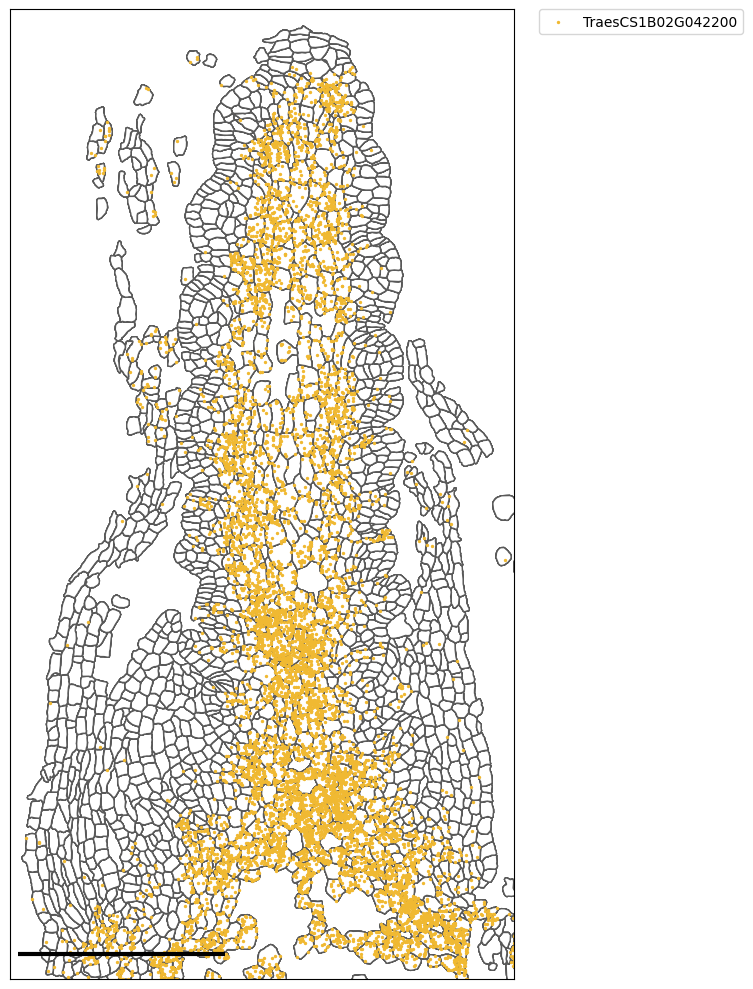

In [82]:
# Define genes and colors
genes_of_interest = {
    'TraesCS1B02G042200': '#f0b932'
}


# Define rotation parameters
angle = -22 # Degrees
radians = math.radians(angle)
cos_angle = math.cos(radians)
sin_angle = math.sin(radians)
rotation_matrix = np.array([[cos_angle, -sin_angle], [sin_angle, cos_angle]])

# Calculate the center of the filtered segmentation data for rotation
segmentation_center_x = filtered_segmentation_df['Geometry'].centroid.x.mean()
segmentation_center_y = filtered_segmentation_df['Geometry'].centroid.y.mean()

# Apply rotation to each Polygon in the filtered segmentation data
rotated_patches_list = []
rotated_polygons = []  # Store rotated polygons for containment checks
rotated_centroids = []  # Store centroids of rotated polygons for bin assignment
for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    if isinstance(shape, MultiPolygon):
        for poly in shape.geoms:
            centered_coords = np.array(poly.exterior.coords) - np.array([segmentation_center_x, segmentation_center_y])
            rotated_coords = np.dot(centered_coords, rotation_matrix) + np.array([segmentation_center_x, segmentation_center_y])
            rotated_poly = Polygon(rotated_coords)
            rotated_polygons.append(rotated_poly)
            rotated_centroids.append(rotated_poly.centroid)
            patch = patches.Polygon(rotated_coords, closed=True, facecolor="white", edgecolor='#595959', linewidth=1)
            rotated_patches_list.append(patch)
    elif isinstance(shape, Polygon):
        centered_coords = np.array(shape.exterior.coords) - np.array([segmentation_center_x, segmentation_center_y])
        rotated_coords = np.dot(centered_coords, rotation_matrix) + np.array([segmentation_center_x, segmentation_center_y])
        rotated_poly = Polygon(rotated_coords)
        rotated_polygons.append(rotated_poly)
        rotated_centroids.append(rotated_poly.centroid)
        patch = patches.Polygon(rotated_coords, closed=True, facecolor="white", edgecolor='#595959', linewidth=1)
        rotated_patches_list.append(patch)

# Apply rotation to transcript coordinates
rotated_transcript_data = {}
for gene, color in genes_of_interest.items():
    transcripts_of_interest = transcripts_in_area[transcripts_in_area['gene'] == gene].copy()
    transcript_coords = transcripts_of_interest[['global_x', 'global_y']].to_numpy()
    centered_transcript_coords = transcript_coords - np.array([segmentation_center_x, segmentation_center_y])
    rotated_transcript_coords = np.dot(centered_transcript_coords, rotation_matrix) + np.array([segmentation_center_x, segmentation_center_y])
    
    # Add rotated transcript coordinates for plotting
    rotated_transcript_data[gene] = {
        'x': rotated_transcript_coords[:, 0],
        'y': rotated_transcript_coords[:, 1],
        'color': color
    }


# Plot the rotated segmentation and transcripts
fig, ax = plt.subplots(figsize=(10, 10))

# Add rotated segmentation polygons
collection = PatchCollection(rotated_patches_list, match_original=True)
ax.add_collection(collection)

# Plot each gene's filtered transcripts with unique colors
for gene, data in rotated_transcript_data.items():
    ax.scatter(data['x'], data['y'], color=data['color'], s=2, alpha=1, label=gene)

# Set axis limits
ax.set_ylim(6650, 7825)
ax.set_xlim(3610, 4220)
ax.set_aspect('equal')

# Place the legend outside the plot
ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0, prop=dict(size=10))

# Add a 25-micron scale bar
scale_bar_length = 250  # Microns
x_start = 3620  # Starting x-coordinate of the scale bar
y_start = 6680  # Starting y-coordinate of the scale bar
x_end = x_start + scale_bar_length  # Ending x-coordinate of the scale bar

# Draw the scale bar line
ax.hlines(y_start, x_start, x_end, colors='black', linewidth=3)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])


plt.tight_layout()
plt.savefig('enrichmentanalysis/VGN1e1_MT2map_250scalebar.svg', dpi=700, bbox_inches='tight', format='png', transparent=True)
plt.show()


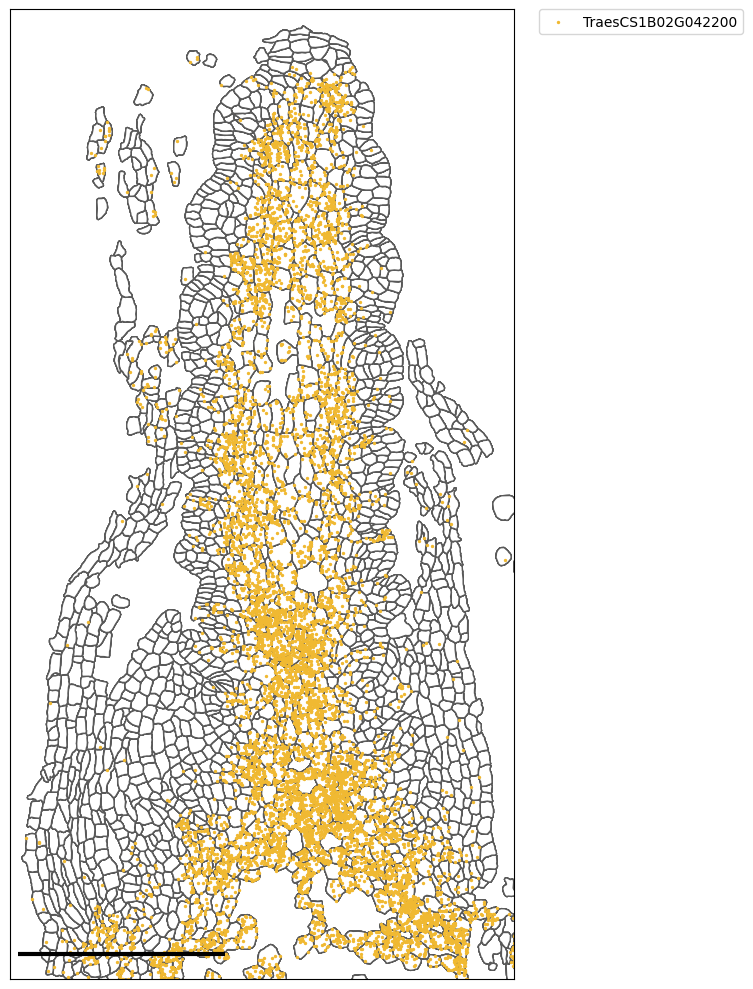

In [83]:
# Define genes and colors
genes_of_interest = {
    'TraesCS1B02G042200': '#f0b932'
}


# Define rotation parameters
angle = -22 # Degrees
radians = math.radians(angle)
cos_angle = math.cos(radians)
sin_angle = math.sin(radians)
rotation_matrix = np.array([[cos_angle, -sin_angle], [sin_angle, cos_angle]])

# Calculate the center of the filtered segmentation data for rotation
segmentation_center_x = filtered_segmentation_df['Geometry'].centroid.x.mean()
segmentation_center_y = filtered_segmentation_df['Geometry'].centroid.y.mean()

# Apply rotation to each Polygon in the filtered segmentation data
rotated_patches_list = []
rotated_polygons = []  # Store rotated polygons for containment checks
rotated_centroids = []  # Store centroids of rotated polygons for bin assignment
for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    if isinstance(shape, MultiPolygon):
        for poly in shape.geoms:
            centered_coords = np.array(poly.exterior.coords) - np.array([segmentation_center_x, segmentation_center_y])
            rotated_coords = np.dot(centered_coords, rotation_matrix) + np.array([segmentation_center_x, segmentation_center_y])
            rotated_poly = Polygon(rotated_coords)
            rotated_polygons.append(rotated_poly)
            rotated_centroids.append(rotated_poly.centroid)
            patch = patches.Polygon(rotated_coords, closed=True, facecolor="white", edgecolor='#595959', linewidth=1)
            rotated_patches_list.append(patch)
    elif isinstance(shape, Polygon):
        centered_coords = np.array(shape.exterior.coords) - np.array([segmentation_center_x, segmentation_center_y])
        rotated_coords = np.dot(centered_coords, rotation_matrix) + np.array([segmentation_center_x, segmentation_center_y])
        rotated_poly = Polygon(rotated_coords)
        rotated_polygons.append(rotated_poly)
        rotated_centroids.append(rotated_poly.centroid)
        patch = patches.Polygon(rotated_coords, closed=True, facecolor="white", edgecolor='#595959', linewidth=1)
        rotated_patches_list.append(patch)

# Apply rotation to transcript coordinates
rotated_transcript_data = {}
for gene, color in genes_of_interest.items():
    transcripts_of_interest = transcripts_in_area[transcripts_in_area['gene'] == gene].copy()
    transcript_coords = transcripts_of_interest[['global_x', 'global_y']].to_numpy()
    centered_transcript_coords = transcript_coords - np.array([segmentation_center_x, segmentation_center_y])
    rotated_transcript_coords = np.dot(centered_transcript_coords, rotation_matrix) + np.array([segmentation_center_x, segmentation_center_y])
    
    # Add rotated transcript coordinates for plotting
    rotated_transcript_data[gene] = {
        'x': rotated_transcript_coords[:, 0],
        'y': rotated_transcript_coords[:, 1],
        'color': color
    }


# Plot the rotated segmentation and transcripts
fig, ax = plt.subplots(figsize=(10, 10))

# Add rotated segmentation polygons
collection = PatchCollection(rotated_patches_list, match_original=True)
ax.add_collection(collection)

# Plot each gene's filtered transcripts with unique colors
for gene, data in rotated_transcript_data.items():
    ax.scatter(data['x'], data['y'], color=data['color'], s=2, alpha=1, label=gene)

# Set axis limits
ax.set_ylim(6650, 7825)
ax.set_xlim(3610, 4220)
ax.set_aspect('equal')

# Place the legend outside the plot
ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0, prop=dict(size=10))

# Add a 25-micron scale bar
scale_bar_length = 250  # Microns
x_start = 3620  # Starting x-coordinate of the scale bar
y_start = 6680  # Starting y-coordinate of the scale bar
x_end = x_start + scale_bar_length  # Ending x-coordinate of the scale bar

# Draw the scale bar line
ax.hlines(y_start, x_start, x_end, colors='black', linewidth=3)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])


plt.tight_layout()
plt.savefig('enrichmentanalysis/VGN1e1_MT2map_250scalebar.png', dpi=700, bbox_inches='tight', format='png')
plt.show()


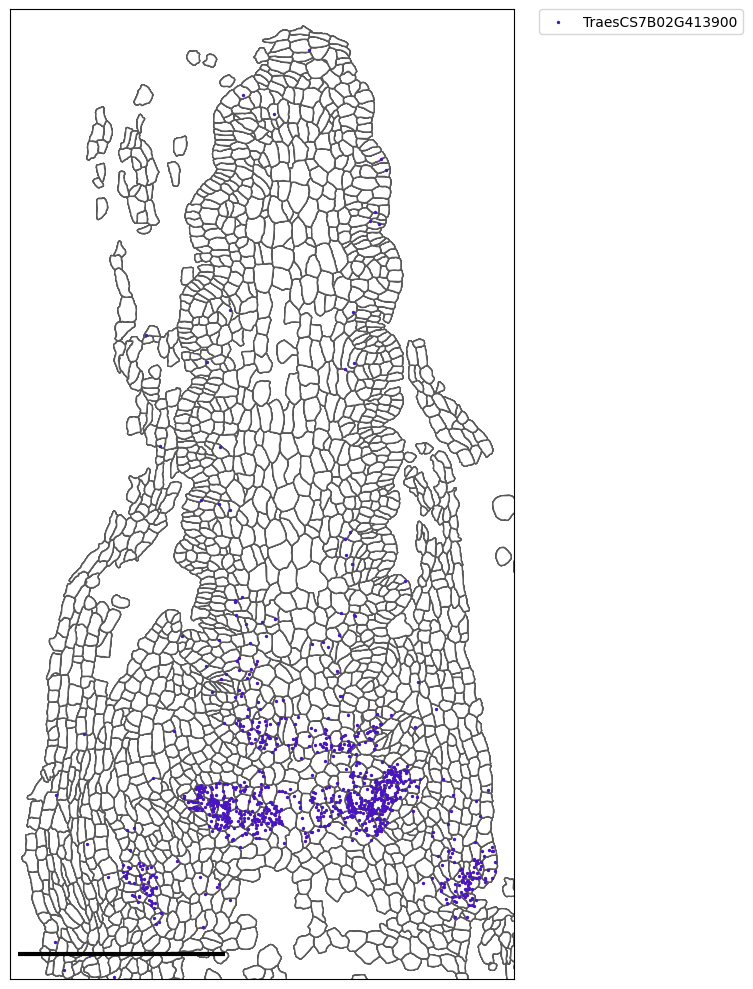

In [84]:
# Define genes and colors
genes_of_interest = {
    'TraesCS7B02G413900': '#4915be'
}


# Define rotation parameters
angle = -22 # Degrees
radians = math.radians(angle)
cos_angle = math.cos(radians)
sin_angle = math.sin(radians)
rotation_matrix = np.array([[cos_angle, -sin_angle], [sin_angle, cos_angle]])

# Calculate the center of the filtered segmentation data for rotation
segmentation_center_x = filtered_segmentation_df['Geometry'].centroid.x.mean()
segmentation_center_y = filtered_segmentation_df['Geometry'].centroid.y.mean()

# Apply rotation to each Polygon in the filtered segmentation data
rotated_patches_list = []
rotated_polygons = []  # Store rotated polygons for containment checks
rotated_centroids = []  # Store centroids of rotated polygons for bin assignment
for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    if isinstance(shape, MultiPolygon):
        for poly in shape.geoms:
            centered_coords = np.array(poly.exterior.coords) - np.array([segmentation_center_x, segmentation_center_y])
            rotated_coords = np.dot(centered_coords, rotation_matrix) + np.array([segmentation_center_x, segmentation_center_y])
            rotated_poly = Polygon(rotated_coords)
            rotated_polygons.append(rotated_poly)
            rotated_centroids.append(rotated_poly.centroid)
            patch = patches.Polygon(rotated_coords, closed=True, facecolor="white", edgecolor='#595959', linewidth=1)
            rotated_patches_list.append(patch)
    elif isinstance(shape, Polygon):
        centered_coords = np.array(shape.exterior.coords) - np.array([segmentation_center_x, segmentation_center_y])
        rotated_coords = np.dot(centered_coords, rotation_matrix) + np.array([segmentation_center_x, segmentation_center_y])
        rotated_poly = Polygon(rotated_coords)
        rotated_polygons.append(rotated_poly)
        rotated_centroids.append(rotated_poly.centroid)
        patch = patches.Polygon(rotated_coords, closed=True, facecolor="white", edgecolor='#595959', linewidth=1)
        rotated_patches_list.append(patch)

# Apply rotation to transcript coordinates
rotated_transcript_data = {}
for gene, color in genes_of_interest.items():
    transcripts_of_interest = transcripts_in_area[transcripts_in_area['gene'] == gene].copy()
    transcript_coords = transcripts_of_interest[['global_x', 'global_y']].to_numpy()
    centered_transcript_coords = transcript_coords - np.array([segmentation_center_x, segmentation_center_y])
    rotated_transcript_coords = np.dot(centered_transcript_coords, rotation_matrix) + np.array([segmentation_center_x, segmentation_center_y])
    
    # Add rotated transcript coordinates for plotting
    rotated_transcript_data[gene] = {
        'x': rotated_transcript_coords[:, 0],
        'y': rotated_transcript_coords[:, 1],
        'color': color
    }


# Plot the rotated segmentation and transcripts
fig, ax = plt.subplots(figsize=(10, 10))

# Add rotated segmentation polygons
collection = PatchCollection(rotated_patches_list, match_original=True)
ax.add_collection(collection)

# Plot each gene's filtered transcripts with unique colors
for gene, data in rotated_transcript_data.items():
    ax.scatter(data['x'], data['y'], color=data['color'], s=2, alpha=1, label=gene)

# Set axis limits
ax.set_ylim(6650, 7825)
ax.set_xlim(3610, 4220)
ax.set_aspect('equal')

# Place the legend outside the plot
ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0, prop=dict(size=10))

# Add a 25-micron scale bar
scale_bar_length = 250  # Microns
x_start = 3620  # Starting x-coordinate of the scale bar
y_start = 6680  # Starting y-coordinate of the scale bar
x_end = x_start + scale_bar_length  # Ending x-coordinate of the scale bar

# Draw the scale bar line
ax.hlines(y_start, x_start, x_end, colors='black', linewidth=3)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])


plt.tight_layout()
plt.savefig('enrichmentanalysis/VGN1e1_MNDmap_250scalebar.png', dpi=700, bbox_inches='tight', format='png', transparent=True)
plt.show()
